# text-mining exploration of Hakluyt

##### imports, setup, HK functions code #####

In [66]:
# various imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from collections import Counter

#plot size setup
plt.rcParams["figure.figsize"] = (12,5)

# pandas settings to use its dataframe for printing tables
pd.set_option("display.max_rows", None, "display.max_columns", None, 'display.width', 1000)

# basic metadata retrieval functions against the Hakluyt txt files
# cf. Hakluyt_pdfminer extract from CambridgeCore pdfs.ipynb, 
# FineReader texts processing .ipynb
# & Hakluyt txt ledger.ipynb
test_filename = '01_44_NNE-_1313_The_letters_of_Edward_the_second_unto_Haquinus_King_of_Norway_concerning_certain_English_Merchants_a_pp.339-343.txt'

def HK_date(fileid):
    #extracts date component from Hakluyt text file name, returns as integer
    return(int(fileid[11:15]))
def HK_geog(fileid):
    #extracts geography component from Hakluyt text file name, returns as string
    return(fileid[6:10])
def HK_title(fileid):
    #extracts geography component from Hakluyt text file name, returns as string
    return(fileid[16:-15])
def HK_vol(fileid):
    #extracts volume component from Hakluyt text file name, returns as integer
    return(int(fileid[:2]))
def HK_chap(fileid):
    #extracts chapter component from Hakluyt text file name, returns as integer
    return(int(fileid[3:5]))
def HK_pages(fileid):
    #extracts page range component from Hakluyt text file name, returns as tuple of integers
    pages_char = fileid[-11:-4]
    pages_char_split = pages_char.split('-')
    return(int(pages_char_split[0]), int(pages_char_split[1]))
def HK_page_length(fileid):
    #extracts page length component from Hakluyt text file name, returns as integer
    first_page, last_page = HK_pages(fileid)
    return(last_page-first_page+1)

In [67]:
#returning tags based on ledger file
import os
import csv
def HK_tags(fileid):
    with open('text-data/ledgertagged.csv') as ledgertaggedcsv:
        ledger = csv.DictReader(ledgertaggedcsv, delimiter = ",")
        tags = []
        for row in ledger:
            if int(row['vol'])==HK_vol(fileid) and int(row['chap'])==HK_chap(fileid):
                tags.append(row['tag1'])
                if row['tag2']:
                    tags += row['tag2'].split(", ")
    return(tags)

In [68]:
# # s, e = HK_pages(test_filename)
# print(HK_tags(test_filename))

##### chapter length spread code #####

In [69]:
# setting up basic text corpuses

import nltk
from nltk.corpus import PlaintextCorpusReader
# unfiltered corpuses
corpus_root = 'text-data/Cambridge_MacLehose_FineReader_OCR_trimmed'
hakluyt = PlaintextCorpusReader(corpus_root, '.*')
from nltk.text import TextCollection
hakluyt_col = TextCollection(hakluyt)

In [70]:
# setting up text corpuses based on MorphAdorn's lemmatization

corpus_lem_path = 'text-data/CC_ML_FR_trimmed_morphad_lem'
hakluyt_lem = PlaintextCorpusReader(corpus_lem_path, '.*')

In [71]:
# setting up categorized corpus based on both the nar/doc and the extended tags
# reminder that nar vs doc is a neat exclusive division of the corpus into two bins, 
# while the other tags both overlap and skip
filelist = os.listdir(corpus_lem_path)
fileid_tags = {}
with open('text-data/ledgertagged.csv') as ledgertaggedcsv:
    ledger = csv.DictReader(ledgertaggedcsv, delimiter = ",")
    for file in filelist:
        fileid_tags[file] = HK_tags(file)
from nltk.corpus import CategorizedPlaintextCorpusReader
hakluyt_lem_cat_tags = CategorizedPlaintextCorpusReader(corpus_lem_path, '.*', cat_map = fileid_tags)

In [72]:
# setting up categorized corpus based on geography
# should in principle work by extracting category from filename but doesn't

# import re
# hakluyt_cat_geog = CategorizedPlaintextCorpusReader(corpus_root, '.*', cat_pattern = r'(NNE-|SSE1|SSE2|AMER)')
# hakluyt_cat_geog.categories()
# re.findall(r'NNE-|SSE1|SSE2|AMER', r'01_16_NNE-_1246_Libellus_historicus_Johannis_de_Plano_Carpini_pp.055-094')

In [73]:
# setting up categorized corpus based on geography
#working, if less efficient solution - mirroring the above tags routine

filelist = os.listdir(corpus_lem_path)
fileid_geog = {}
for file in filelist:
    fileid_geog[file] = [HK_geog(file)]
from nltk.corpus import CategorizedPlaintextCorpusReader
hakluyt_lem_cat_geog = CategorizedPlaintextCorpusReader(corpus_lem_path, '.*', cat_map = fileid_geog)

In [74]:
# chapter / word counts for every geog region as a separate category and then for all of them together
geogs = ['NNE-', 'SSE1', 'SSE2', 'AMER']
chapters = [len(hakluyt_lem_cat_geog.fileids(categories = geog)) for geog in geogs + [geogs]]
words = [len(hakluyt_lem_cat_geog.words(categories = geog)) for geog in geogs + [geogs]]
chapters_words_df = pd.DataFrame(columns = [geogs + ['total']], index = ['chapters', 'words', 'avg chap len'])
chapters_words_df.loc['chapters'] = chapters
chapters_words_df.loc['words'] = words
chapters_words_df.loc['avg chap len'] = [int(words[i]/chapters[i]) for i in range(5)]

In [75]:
# chapter date frequency through single region
# cfd = nltk.FreqDist(HK_date(fileid) for fileid in hakluyt_cat_geog.fileids(categories = 'NNE-'))
# x = list(range(270,1600))
# y = [cfd[date] for date in x]
# plt.plot(x,y)
# x2=list(range(270,1600,10))

In [76]:
#histogram with transparency overlay
# for geog in geogs:
#     plt.hist([HK_date(fileid) for fileid in hakluyt_cat_geog.fileids(categories = geog)], bins = 15, alpha=0.5, label = geog)
# plt.legend()
# plt.title('histogram of chapter date frequencies')
# plt.show()

## Basic numeric overview

Hakluyt's second edition of **The Principal Navigations, Voyages, Traffiques and Discoveries of the English Nation**, 1598-1600, was printed in three volumes (expanding on the single-volume 1589 edition); the second volume broken down into two sub-sections as follows:

**NNE-**: "the North and Northeast quarters of the World"

**SSE1**: "the South and South-east quarters of the world, within the Straight of Gibraltar"

**SSE2**: essentially Africa outside of the Mediterranean, followed by southern Asia: "the South and Southeast quarters of the world without the Straights of Gibraltar, namely to the Hands of Madera, and of the Canaries, to the kingdome of Barbarie, to the Iles of Capo Verde, to the River of Senga, to the Coast of Ghinea and Benin, about the Cape of Buona Esperanza, and so to Goa in the East Indies, and likewise beyond cape Comori to the Iles of Nicubar, to Sumatra, to the Channell of Sincapura over against the City of Malacca, and to divers other places"

**AMER**: "the Northwest, West, and Southwest parts of the world"

### chapter and word numbers by geographic region

                NNE-    SSE1    SSE2    AMER    total
chapters         188     144      59     198      589
words         607689  321623  220912  923198  2073422
avg chap len    3232    2233    3744    4662     3520


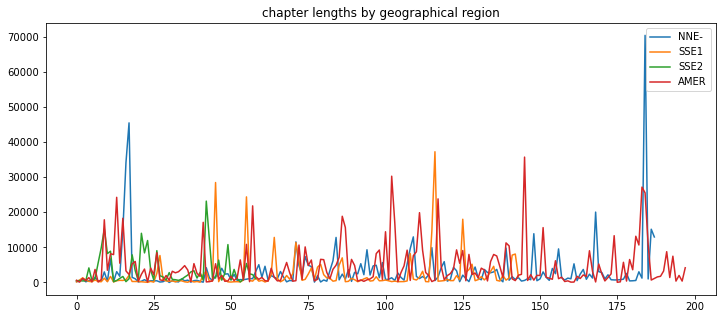

In [77]:
# chapter / word counts for every geog region as a separate category and then for all of them together
print(chapters_words_df)
# simple plotting of chapter lengths to get a sense of the variability
for geog in geogs:
    plt.plot([len(hakluyt_lem_cat_geog.words(fileid)) for fileid in hakluyt_lem_cat_geog.fileids(categories = geog)], label = geog)
plt.legend()
plt.title('chapter lengths by geographical region')
plt.show()

Interestingly, the American volume is not only the longest one in both chapter number and word length, but also has the longest chapters on average; it accounts for nearly half the collection, despite the fact that the English have barely started engaging with the new continent, and Europeans overall have just about one century of well-documented American encounters, as opposed to thousands of years for Europe, Asia and Africa. Hakluyt is clearly singling it out for special treatment. Africa outside the Mediterranean and South Asia, on the other hand, get a definite short shrift. There's a good deal of chapter length variability in each region, but NNE takes the lead with two outliers longer than any other chapter in any region.

In [78]:
# am_lens = [len(hakluyt_lem_cat_geog.words(fileid)) for fileid in hakluyt_lem_cat_geog.fileids(categories = 'AMER')]
# import statistics
# print('median American chapter length is ', statistics.median(am_lens), ' words, which, at about 360 words for a crammed page, comes to ', statistics.median(am_lens)/360, ' pages.')
# statistics.mean(am_lens)

### chapter date distributions by geographic region

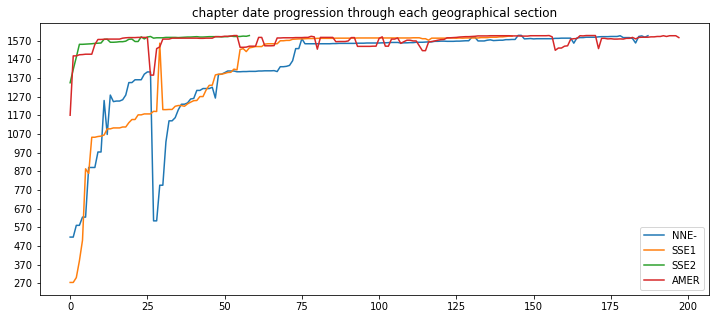

In [79]:
for geog in geogs:
    plt.plot([HK_date(fileid) for fileid in hakluyt_lem_cat_geog.fileids(categories = geog)], label = geog)
plt.legend()
plt.yticks(range(270, 1600, 100))
plt.title('chapter date progression through each geographical section')
plt.show()

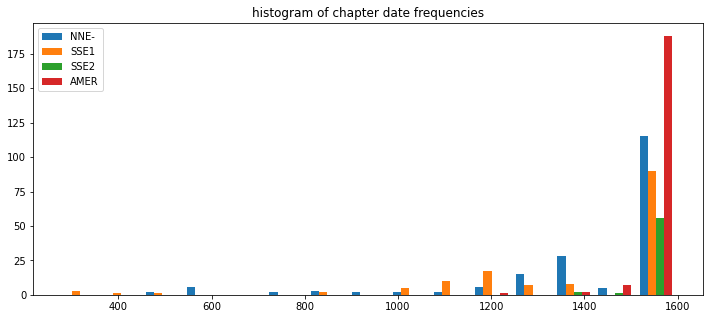

In [80]:
store={}
for geog in geogs:
    store[geog] = [HK_date(fileid) for fileid in hakluyt_lem_cat_geog.fileids(categories = geog)]
plt.hist([store[geog] for geog in geogs], bins=15, label = geogs)
plt.legend()
plt.title('histogram of chapter date frequencies')
plt.show()

Clearly, the compilation is heavily skewed in favor of the most recent few decades. While this is true across the board, however, there are differences in detail. Both the very short section on extra-Mediterranean Africa & South Asia and the extended American section only briefly touch on past centuries before jumping up to more recent times--very understandably in the latter case, as Europe had scant recorded pre-16th c. encounters with America. North Europe & Russia, as well as the Mediterranean region, on the other hand, do have longer historical tails, though these are still quite minor. Curiously, all but the extra-Med sections show a dramatic deviation about the 26th chapter in each, suggesting a bit of a narrative departure, though this seems much more a matter of coincidence rather than design. For NNE, the dip coincides with a switch from narrative to accompanying documents, SSE1, the single chapter that jumps forward in time relates a contemporary note addressing the older period, and in AMER, the two documents that create the visible dip (neither going very far back) simply go back to an older voyage.

#### The basics of Hakluyt's exploration discourse -- top frequent word counts

##### word frequencies prep code

In [370]:
# word frequencies setup
import string

from nltk.corpus import stopwords
from nltk import ngrams

eliz_stopwords = ["i",  "me",  "my",  "myself",  "we",  "our",  "ours",  "ourselves",  "you",  "your",  "yours",  "yourself",  "yourselves",  "he",  "him",  "his",  "himself",  "she",  "her",  "hers",  "herself",  "it",  "its",  "itself",  "they",  "them",  "their",  "theirs",  "themselves",  "what",  "which",  "who",  "whom",  "this",  "that",  "these",  "those",  "am",  "is",  "are",  "was",  "were",  "be",  "been",  "being",  "have",  "has",  "had",  "having",  "do",  "does",  "did",  "doing",  "a",  "an",  "the",  "and",  "but",  "if",  "or",  "because",  "as",  "until",  "while",  "of",  "at",  "by",  "for",  "with",  "about",  "against",  "between",  "into",  "through",  "during",  "before",  "after",  "above",  "below",  "to",  "from",  "up",  "down",  "in",  "out",  "o",  "on",  "off",  "over",  "under",  "again",  "further",  "then",  "once",  "here",  "there",  "when",  "where",  "why",  "how",  "all",  "any",  "both",  "each",  "few",  "more",  "most",  "other",  "some",  "such",  "no",  "nor",  "not",  "only",  "own",  "same",  "so",  "than",  "too",  "very",  "can",  "will",  "just",  "should",  "now",  "art", "doth", "dost", "'ere", "hast", "hath", "hence", "hither", "nigh", "oft", "should'st", "thither", "thee", "thou", "thine", "thy", "'tis", "'twas", "wast", "whence", "wherefore", "whereto", "withal", "would'st", "ye", "yon", "yonder"]
hk_stopwords = ['unto','u','upon','de','also','wee','may','would','shall','hee','like','doe','could','much','every','againe','bee','might','without','well','within','yet','bene','ad','another','whereof','thereof','onely','next','himselfe','thus','untill','therefore','cum','selfe','non','ut', 'whole','little','full','neither','among','last','c','never','la','qui','ii','according','whose','either','per','along','item','al','likewise','mee','whereupon','till','able','self','el','que','mine','quae','sunt','et','although','litle','si','notwithstanding','besides','etiam','e','even','vel','alwayes', 'ever','rather','whether','still','otherwise','amongst', 'somewhat','ex','aforesaid','though','whatsoever','quam', 'ten','whereby','foorth','no', 'n','los','almost','howbeit','j', 'greatly','ac','yce', 'pro','en','ab','greatest','whereas','hoc','w','beene','doeth','eorum','con','withall','hereafter','moreover','nec','noone','omnes','del','enim','often']
latin_stopwords = ['ab', 'ac', 'ad', 'adhuc', 'aliqui', 'aliquis', 'an', 'ante', 'apud', 'at', 'atque', 'aut', 'autem', 'cum', 'cur', 'de', 'deinde', 'dum', 'ego', 'enim', 'ergo', 'es', 'est', 'et', 'etiam', 'etsi', 'ex', 'fio', 'haud', 'hic', 'iam', 'idem', 'igitur', 'ille', 'in', 'infra', 'inter', 'interim', 'ipse', 'is', 'ita', 'magis', 'modo', 'mox', 'nam', 'ne', 'nec', 'necque', 'neque', 'nisi', 'non', 'nos', 'o', 'ob', 'per', 'possum', 'post', 'pro', 'quae', 'quam', 'quare', 'qui', 'quia', 'quicumque', 'quidem', 'quilibet', 'quis', 'quisnam', 'quisquam', 'quisque', 'quisquis', 'quo', 'quoniam', 'sed', 'si', 'sic', 'sive', 'sub', 'sui', 'sum', 'super', 'suus', 'tam', 'tamen', 'trans', 'tu', 'tum', 'ubi', 'uel', 'uero']
pronouns = ['i', 'you', 'he', 'she', 'it', 'we', 'you', 'they', 'me', 'you', 'him', 'her', 'it', 'you', 'us', 'them', 'my', 'your', 'his', 'her', 'its', 'our', 'your', 'their', 'mine', 'yours', 'his', 'hers', 'its', 'ours', 'yours', 'theirs', 'myself', 'yourself', 'himself', 'herself', 'itself', 'ourselves', 'yourselves', 'themselves']
modals = ['shall','shal','shalt','should', 'can', "can't", 'cannot', 'could', 'will','wil', 'would', 'may', 'must', 'might', 'ought', 'need', 'have', 'has']
directives = ['without', 'within', 'there', 'thence','away','est','towards','toward','farre','betweene','wherein','therein']
numbers = ['least','lesse','none','halfe','one','two','second', 'three','iii','third','foure','four','five','sixe','seven','eight','nine','twelve','hundred','thousand','many','large','greater']
punctuation = [i for i in string.punctuation]
stop_words = list(set(stopwords.words('english') + latin_stopwords + eliz_stopwords + hk_stopwords + ['']) - set(pronouns + modals + directives))
stop_words_max = stop_words + pronouns + modals + directives + ['great', 'make', 'good', 'part', 'certain', 'thing', 'wherewith', 'afterward', 'day']

viol_flags = ['violence', 'harm', 'injury', 'injure', 'hurt', 'damage', 'scathe', 'wound', 'maim', 'cripple', 'mutilate', 'cut', 'mangle', 'torture', 'torment', 'wound', 'gash', 'bruise', 
              'bloody', 'bloodshed', 'bloodshedder', 'bloodshedding', 'blood', 'hit', 'strike', 'beat', 'revenge', 'subdue', 'vanquish', 'rob', 'robbery', 'assail', 'assailant',   
              'fight', 'scrap', 'struggle', 'conflict', 'melee', 'brawl', 'combat', 'wrestle', 'wrestler',
              'kill', 'death', 'slay', 'murder', 'assassinate', 'assassin', 'massacre', 'slaughter', 'butcher', 'slaughter', 'manslaughter', 
              'battle', 'war', 'siege', 'attack', 'assault', 'skirmish', 'skirmisher', 'enemy', 'foe', 'hostile', 'army', 'soldier', 'warrior', 'conquer', 'conqueror', 'conquest', 'invade', 'invasion', 'invaded', 'rebel', 'mutiny',
              'detain', 'capture', 'captive', 'imprison', 'imprisonment', 'gaol', 'prisoner', 'prison', 'slave', 'enslave', 'punish', 'victory', 'resist', 'resitance', 'surprise', 'mutiny', 'mutinous',
              'shoot', 'shot',  'blast', 'burn', 'fire', 'blaze',
              'cruel', 'cruelty', 'destroy', 
              'weapon','arrow', 'crossbow', 'dart', 'javelin', 'mace', 'club', 'sword', 'lance', 'spear', 'rapier', 'pike', 'target', 'buckler', 'falchion', 'halberd', 'partisan', 'dagger',
              'musket', 'gun', 'gunner', 'bullet', 'caliver', 'culverin', 'harquebus', 'harquebusier', 'harquebuss', 'saker', 'cannon', 'artillery', 'munition', 'gunpowder', 'handgun', 'volley', 'canon']
viol_poss = ['ordinance','armour', 'fortress', 'fort', 'defence', 'bulwark', 'die', 'pain', 'piece', 'discharge', 'charge', 'powder', 'spoil', 'abuse', 'steal', 'knife', 'hatchet', 'poison', 'fire', 'bow', 'force', 'pain', 'sink', 'hang', 'blow', 'breach', 'warlike', 'execute', 'execution'] 

In [82]:
#figuring out additional stopwords

# for word in hakluyt_lem_fd.most_common(200):
#     if word[0] not in stop_words_max:
#         print(word)

In [83]:
def compare_freqs(standard, comp):
    '''
    takes in 2 frequent words counts (outputs of FreqDist.most_common(x))
    and returns the second count with an indicator of
    how many spaces the token moved up/down in the list 
    (or 'new' if the token has not appeared on the original list)
    arguments:
    - standard: the 'source' count
    - comp: the 'new' count, to be compared to the 'source'
    returns: 'comp' count plus change indicator
    '''
    ret = comp
    for i in range(len(standard)):
        s_token = standard[i][0]
        for j in range(len(comp)):
            if comp[j][0] == s_token:
                change = i-j
                change = '+' + str(change) if change > 0 else str(change)
                ret[j] = (comp[j][0], comp[j][1], change)
    for k in range(len(ret)):
        if len(ret[k]) == 2:
            ret[k] = (ret[k][0], ret[k][1], 'new')
    return(ret)

In [84]:
#display styles for tables generated with compare_freqs
# def highlight_shifts(x):
#     return ["" if len(token) < 3 else "background: orange" if (token[2] == 'new' or abs(int(token[2])) > 100) else "background: yellow" if abs(int(token[2])) > 15 else "" for token in x]
def highlight_shifts(x):
    return ["" if len(token) < 3 else "background: orange" if (token[2] == 'new' or abs(int(token[2])) > 100) 
            else "background: yellow" if abs(int(token[2])) > 15
            else "background: #fdff99" if abs(int(token[2])) > 10
            else "background: #feffd6" if abs(int(token[2])) > 5
            else "" for token in x]
def red_viol(x):
    return ['color: red' if token[0] in viol_flags else "" for token in x]
def bold_viol(x):
    return ["font-weight: bold" if token[0] in viol_flags else "" for token in x]
def redbold_viol(x):
    return ['color: red; font-weight: bold' if token[0] in viol_flags else "" for token in x]

In [85]:
import re
def clean_token(token):
    '''loweraces and discards non-alpha characters'''
    token = token.lower()
    token = re.sub(r'\W+', '', token)
    return(token)

In [86]:
# word freq filtered for stopwords and non-letter chars
hakluyt_filtered = [clean_token(t) for t in hakluyt.words() if t not in stop_words and t.isalpha()]
hakluyt_fd = nltk.FreqDist(hakluyt_filtered) 

# word freq with MorphAdorn's lemmatization
# for reference: MA cmd line adornplainemetext \C:\Users\apovzner\Documents\Hakluyt\adorned \C:\Users\apovzner\Documents\Hakluyt\Cambridge MacLehose FineReader OCR\*.txt
hakluyt_lem_filtered = [clean_token(t) for t in hakluyt_lem.words() if t not in stop_words and t.isalpha()]
hakluyt_lem_fd = nltk.FreqDist(hakluyt_lem_filtered)

In [87]:
# #frequent bigrams / trigrams don't seem to offer much, even with added stopwords
# ngram_fd = nltk.FreqDist(nltk.bigrams(hakluyt_lem_filtered))
# for bigram in ngram_fd.most_common(250):
#     print(bigram)

# ngram_fd = nltk.FreqDist(nltk.trigrams(hakluyt_lem_filtered))
# for trigram in ngram_fd.most_common(250):
#     print(trigram)

Technical notes:
- NLTK's lemmatization was quite annoyingly cutting 'us' down to 'u'
- MorphAdorn's routine doesn't seem to do that, but it does collapse some pronouns, including, I think, 'us' to 'we'
- While the lemmatization doesn't change the order of the most frequent tokens much, it does increase the displayed counts substantially, suggesting that it's succeeding at bringing together (hopefully relevant) word clusters

- bigram/trigram frequencies didn't yield much of use: while single words are easy to interpret as content-bearers, ngrams seem to single out stock phrases and collocations, perhaps more indicative of language/form than content

##### essential discursive consistency:

In [88]:
# top frequent words in HK global vs split by geography
hakluyt_lem_filtered = [t for t in hakluyt_lem.words() if (t.isalpha() and t not in stop_words)]
hakluyt_lem_cat_geog_fd = nltk.ConditionalFreqDist(
                                (geog, word)
                                for geog in geogs
                                for word in hakluyt_lem_cat_geog.words(categories = geog)
                                if word.isalpha() and word not in stop_words)

# top frequent words in HK global vs split by narrative / document
hakluyt_lem_cat_nardoc_fd = nltk.ConditionalFreqDist(
                                (tag, word)
                                for tag in ['nar', 'doc']
                                for word in hakluyt_lem_cat_tags.words(categories = tag)
                                if word.isalpha() and word not in stop_words)

wordfreqs_partitioned = pd.DataFrame()
wordfreqs_partitioned['total'] = hakluyt_lem_fd.most_common(500)
for geog in geogs:
    wordfreqs_partitioned[geog] = compare_freqs(hakluyt_lem_fd.most_common(500), hakluyt_lem_cat_geog_fd[geog].most_common(500))
for tag in ['nar', 'doc']:
    wordfreqs_partitioned[tag] = compare_freqs(hakluyt_lem_fd.most_common(500), hakluyt_lem_cat_nardoc_fd[tag].most_common(500))

In [89]:
wordfreqs_partitioned.T.style.apply(highlight_shifts).apply(redbold_viol)

- overall the top terms are consistent across all groupings
- the most dramatic shifts in geographical groupings are, predictably, once that are obviously geography-bound
- the variation between narrative and document, too, seems fairly minor (though classification may be at fault here--after all, this is a late editorial intervention rather than Hakluyt's choice)
- explicit violence markers show up in the Mediterranean and Africa / South Asia much earlier than elsewhere (as early as in English histories below)--possibly reflecting Ottoman hostilities

#### top 15 frequent words tracked over time

##### code

In [90]:
def track_words_chapters(corpus, targets, words_mode = 'separate', count_mode = 'absolute'):
    '''
    takes a list of words and prints a graph of their appearance in the corpus, 
    tracking them separately or as the entire group depending on words_mode 
    and counting number of occurrences or proportion of total words depending on count_mode
    arguments:
    corpus: nltk plaintext corpus to track the words in
    targets: list of strings providing the targets for tracking
    words_mode: flag argument taking 'separate' to track each word on its own or 'grouped' to add them all together
    count_mode: flag argument taking 'absolute' to count number of word occurrences or 'relative' to count proportion of total chapter words
    '''
    tracker = {}
    for fileid in corpus.fileids():
        ch = fileid[:11]
        tracker[ch] = Counter()
        for word in corpus.words(fileid):
            if word in targets:
                if words_mode == 'separate':
                    tracker[ch][word] += 1
                elif words_mode == 'grouped':
                    tracker[ch]['target'] += 1
                else:
                    raise ValueError('unrecognized words_mode argument')
            tracker[ch]['total'] += 1

    x = list(tracker.keys())
    if count_mode == 'absolute':
        if words_mode == 'separate':
            for word in targets:
                y = [chapter[word] for chapter in tracker.values()]
                plt.plot(x,y, label = word)
        elif words_mode == 'grouped':
            y = [chapter['target'] for chapter in tracker.values()]
            plt.plot(x,y)
        else:
            raise ValueError('unrecognized count_mode argument')
    elif count_mode == 'relative':
        if words_mode == 'separate':
            for word in targets:
                y = [0 if chapter['total'] == 0 else chapter[word] / chapter['total'] for chapter in tracker.values()]
                plt.plot(x,y, label = word)
        elif words_mode == 'grouped':
            y = [0 if chapter['total'] == 0 else chapter['target'] / chapter['total'] for chapter in tracker.values()]
            plt.plot(x,y)
        else:
            raise ValueError('unrecognized count_mode argument')
    else:
        raise ValueError('unrecognized count_mode argument')
    if words_mode == 'separate':
        plt.title('frequency of targets through the chapters in ' + count_mode + ' values')
        plt.legend()
    else:
        plt.title('frequency of ' + str(targets) + ' through the chapters in ' + count_mode + ' values')
    plt.xticks(x[::15], rotation = 'vertical')
    plt.show()

In [91]:
# plausible improvement: overlaying absolute and relative values, see link below
# https://cmdlinetips.com/2019/10/how-to-make-a-plot-with-two-different-y-axis-in-python-with-matplotlib/
# def track_words_chapters(corpus, targets, words_mode = 'separate'):
#     '''
#     takes a list of words and prints a graph of their appearance in the corpus, 
#     tracking them separately or as the entire group depending on words_mode 
#     and counting number of occurrences or proportion of total words depending on count_mode
#     arguments:
#     corpus: nltk plaintext corpus to track the words in
#     targets: list of strings providing the targets for tracking
#     words_mode: flag argument taking 'separate' to track each word on its own or 'grouped' to add them all together
#     count_mode: flag argument taking 'absolute' to count number of word occurrences or 'relative' to count proportion of total chapter words
#     '''
#     tracker = {}
#     for fileid in corpus.fileids():
#         ch = fileid[:11]
#         tracker[ch] = Counter()
#         for word in corpus.words(fileid):
#             if word in targets:
#                 if words_mode == 'separate':
#                     tracker[ch][word] += 1
#                 elif words_mode == 'grouped':
#                     tracker[ch]['target'] += 1
#                 else:
#                     raise ValueError('unrecognized words_mode argument')
#             tracker[ch]['total'] += 1

#     x = list(tracker.keys())
    
#     if words_mode == 'separate':
#         for word in targets:
#             y = [chapter[word] for chapter in tracker.values()]
#             plt.plot(x,y, label = word)
#     elif words_mode == 'grouped':
#         y = [chapter['target'] for chapter in tracker.values()]
#         plt.plot(x,y)
#     else:
#         raise ValueError('unrecognized count_mode argument')
    
    
#     if words_mode == 'separate':
#         for word in targets:
#             y1 = [0 if chapter['total'] == 0 else chapter[word] / chapter['total'] for chapter in tracker.values()]
#             plt.plot(x,y1, label = word)
#     elif words_mode == 'grouped':
#         y1 = [0 if chapter['total'] == 0 else chapter['target'] / chapter['total'] for chapter in tracker.values()]
#         plt.plot(x,y1)
#     else:
#         raise ValueError('unrecognized count_mode argument')

#     plt.title('frequency of targets through the chapters')
#     if words_mode == 'separate':
#         plt.legend()
#     plt.xticks(x[::15], rotation = 'vertical')
#     plt.show()

In [92]:
# hakluyt_track_top_prop = {}
# step = 10

# for i in range(270,1600,step):
#     hakluyt_track_top_prop[i] = Counter()
# for fileid in hakluyt_lem.fileids():
#     for word in hakluyt_lem.words(fileid):
#         if word in tops:
#             hakluyt_track_top_prop[HK_date(fileid)//step*step][word]+=1
#         hakluyt_track_top_prop[HK_date(fileid)//step*step]['total']+=1

# x = hakluyt_track_top_prop.keys()
# tops_min = set(tops) - set(['king', 'call', 'ship', 'say'])

# for word in tops:
#     y = [years[word] / (years['total']+0.00000000001) for years in hakluyt_track_top_prop.values()] #+0.00001 to avoid div-zero error
#     plt.plot(x,y, label = word)
# plt.legend()
# plt.title('frequency of the top 15 most common words over time as proportion of all words')
# plt.show()

# else:
#         raise ValueError('unrecognized scope argument')

In [93]:
# top frequent words under most restrictive stopwords in HK global tracked over time
hakluyt_extra_filtered = [t.lower() for t in hakluyt_lem.words() if (t.isalpha() and (t.lower() not in stop_words_max))]
hakluyt_exfd = nltk.FreqDist(hakluyt_extra_filtered)
tops = [token for (token, _) in hakluyt_exfd.most_common(15)]
#print(tops)
hakluyt_track_top_fd = nltk.ConditionalFreqDist((top, HK_date(fileid)//10*10)
                                                for fileid in hakluyt_lem.fileids()
                                                for w in hakluyt_lem.words(fileid)
                                                for top in tops
                                                if w.lower().startswith(top[0]))
    

In [94]:
# plt.rcParams["figure.figsize"] = (20,10)
# plt.yticks(range(270, 1600, 100))
print(" ")

In [95]:
from collections import Counter
hakluyt_track_top_prop = {}
step = 10

for i in range(270,1600,step):
    hakluyt_track_top_prop[i] = Counter()
for fileid in hakluyt_lem.fileids():
    for word in hakluyt_lem.words(fileid):
        if word in tops:
            hakluyt_track_top_prop[HK_date(fileid)//step*step][word]+=1
        hakluyt_track_top_prop[HK_date(fileid)//step*step]['total']+=1
x = hakluyt_track_top_prop.keys()
tops_min = set(tops) - set(['king', 'call', 'ship', 'say'])


##### graph

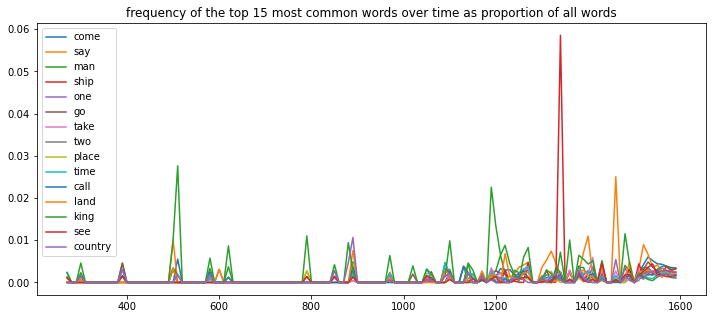

In [96]:
for word in tops:
    y = [years[word] / (years['total']+0.00000000001) for years in hakluyt_track_top_prop.values()] #+0.00001 to avoid div-zero error
    plt.plot(x,y, label = word)
plt.legend()
plt.title('frequency of the top 15 most common words over time as proportion of all words')
plt.show()

Looking at the relative frequency of top terms, we see a significant fluctuation in just a few (likely driven by outlier documents), while the rest vary within a narrow range that shows no discernible pattern of change over time.

#### top frequent words in Hakluyt vs contemporary histories

In [97]:
# top frequent words in HK vs comparison corpus
# setting up comparison text corpus
comparison_path = 'text-data/comparison_texts/lemd'
comparison = PlaintextCorpusReader(comparison_path, '.*')
comparison_filtered = [t.lower() for t in comparison.words() if t not in stop_words and t.isalpha()]
comparison_fd = nltk.FreqDist(comparison_filtered)

wordfreqs_comp = pd.DataFrame()
wordfreqs_comp['comp'] = comparison_fd.most_common(250)
wordfreqs_comp['Hakluyt'] = compare_freqs(comparison_fd.most_common(250), hakluyt_lem_fd.most_common(250))

In [98]:
print(len(comparison.words()), 'words in the comparison corpus initially;', len(comparison_filtered), 'words filtered for stopwords, numbers and punctuation')
print(len(hakluyt.words()), 'words in Hakluyt initially;', len(hakluyt_lem_filtered), 'words filtered for stopwords, numbers and punctuation')
wordfreqs_comp.T.style.apply(redbold_viol).apply(highlight_shifts)

1761831 words in the comparison corpus initially; 822872 words filtered for stopwords, numbers and punctuation
2077367 words in Hakluyt initially; 992669 words filtered for stopwords, numbers and punctuation


Comparing this 'discourse' to a similar word-volume corpus of several English histories (1568-1643), the following jumps out:
- an apparently prominent us-them polarization--probably not so much a distinctively imperial language indication as a stylistic expression of eyewitness narrative accounts (and the different top pronoun distribution in the English histories again probably reflects a tangle of narrative voice convention and subject matter rather than subject matter alone)
- top term movements are fully in line with content that has to do with travel, including a lot of active verbs, geographic designations, and things to do with ships and sailing.
- interestingly, direct indications of violence only start appearing near the 170th place in Hakluyt--lagging behind the English histories at 70 - with much more cropping up around 200
- something of the hidden nature of colonial violence in Hakluyt can be glimpsed through 'take' at 22nd, often denoting capturing or robbing Native people (though 
- worth noting that cleaning up the text files to start and end at chapter titles rather than page number cuts brought the violent terms up by a few places each--likely indicating that they appear less often in first and last paragraph of any text (which is what mostly got cleaned out)

## American Encounters

Introducing hand-tagged American documents, allowing to single out ones fully or significantly concerned with depictions of or interactions with Native people

##### code

In [99]:
# # another failed attempt at cat_pattern solution -- got it to take a single tag for each file, but crashes at two tags
# #setting up categorized corpus based on hand-tags
# AM_cat_root = 'text-data/CC_ML_FR_trimmed_MAlem_AMER_cat_mod/'
# hakluyt_AM_cat = CategorizedPlaintextCorpusReader(AM_cat_root, '.*', cat_pattern = (r'.*?(expl_y|expl_n|enc_full|enc_part|enc_min|enc_none)'))
# hakluyt_AM_cat.categories()
# #re.findall(r'(expl_y|expl_n|enc_full|enc_part|enc_min|enc_none)', r'07_30.2-1578-En-enc_part-expl_y-Frobishers_first_voyage-278_283')
# #.*?_(?:pos|neg)(?:\.txt)?
# #hakluyt_AM_cat.fileids(categories = 'expl_n')

In [100]:
#select stopword threshold
#stop_words_enc = []
stop_words_enc = stop_words_max
#stop_words_enc = stop_words
AM_cat_root = 'text-data/CC_ML_FR_trimmed_MAlem_AMER_cat_mod/'
#setup expl&enc-tagged categorized corpus - working, if not the most efficient solution via catmap rather than pattern

filelist = os.listdir(AM_cat_root)
fileid_cat = {}
for file in filelist:
    fileid_cat[file] = re.findall(r'(expl_y|expl_n|enc_full|enc_part|enc_min|enc_none)', file)
#from nltk.corpus import CategorizedPlaintextCorpusReader
hakluyt_AM_cat = CategorizedPlaintextCorpusReader(AM_cat_root, '.*', cat_map = fileid_cat)

#print('list of categories: ', hakluyt_AM_cat.categories(), 'number of files: ', len(hakluyt_AM_cat.fileids()))

hakluyt_AM_cat_enc_fd = nltk.ConditionalFreqDist((enc, word)
                                                 for enc in ['enc_full', 'enc_min', 'enc_none', 'enc_part']
                                                 for word in hakluyt_AM_cat.words(categories = enc)
                                                if word.isalpha() and word not in stop_words_enc)

# plaintext corpus for just full/part enc
AM_cat_enc_root = 'text-data/CC_ML_FR_trimmed_MAlem_AMER_cat_mod_enc_full_part/'

hakluyt_AM_enc_part_full = PlaintextCorpusReader(AM_cat_root, r'.*(enc_full|enc_part).*')
hakluyt_AM_enc_part_full_fd = nltk.FreqDist(word for word in hakluyt_AM_enc_part_full.words() if word.isalpha() and word not in stop_words_enc)

hakluyt_AM_enc_full = PlaintextCorpusReader(AM_cat_root, r'.*enc_full.*')
hakluyt_AM_enc_full_fd = nltk.FreqDist(word for word in hakluyt_AM_enc_full.words() if word.isalpha() and word not in stop_words_enc)

#plaintext corpus for AMER total
AMER_root = 'text-data/CC_ML_FR_trimmed_morphad_lem_AMER/'

hakluyt_AMER = PlaintextCorpusReader(AMER_root, '.*')
hakluyt_AMER_fd = nltk.FreqDist(word for word in hakluyt_AMER.words() if word.isalpha() and word not in stop_words_enc)

In [101]:
#comparing most frequent words
#hakluyt_AM_cat_enc_fd.most_common(50)
length=350

wordfreqs_enc = pd.DataFrame()
wordfreqs_enc['AM_tot'] = hakluyt_AMER_fd.most_common(length)
#run a comparison against each enc tag separately
for tag in ['enc_none', 'enc_min', 'enc_part', 'enc_full']:
    wordfreqs_enc[tag] = compare_freqs(wordfreqs_enc['AM_tot'], hakluyt_AM_cat_enc_fd[tag].most_common(length))
#run a comparison just against substantial-encounter chapters
wordfreqs_enc['enc_sig'] = compare_freqs(wordfreqs_enc['AM_tot'],hakluyt_AM_enc_part_full_fd.most_common(length))

##### top word comparisons by encounter flags

In [102]:
wordfreqs_enc.T.style.apply(highlight_shifts).apply(red_viol).apply(bold_viol)
#wordfreqs_enc.T.style.apply(lambda x: ["background: orange" if (token[2] == 'new' or abs(int(token[2])) > 100) else "background: yellow" if abs(int(token[2])) > 15 else "" for token in x], axis = 1).apply(lambda x: ["font-weight: bold" if token[0] in viol_flags else "" for token in x], axis = 1).apply(lambda x: ["color: red" if token[0] in viol_flags else "" for token in x], axis = 1)

Held against the total frequencies of the American section, the encounter-focused sections display interesting patterns of word frequency shifts. Granted, the occasional irregularities in these shifts over the process of refining the table are a strong reminder that, with the lower quantity of text at hand, some of these are bound to be just random effects of text selection--but the aggregate is still significant. I will focus on enc_full, where the effects are most dramatic, but these are largely borne out by enc_sig (aggregating enc_full with enc_part), too.

We see positive jumps in 'people', 'Indians', as well as 'savage'--reflecting the main subject matter of the encounter ('town', interestingly, goes down 52 spots, and city-- down 78--apparently European travelers are much more likely to use these words for European than Native settlements). We see dramatic jumps in 'lord', 'king', and 'Paracoussy', reflecting high-tier negotiations, 'old' may be part of the same trajectory. Woman and child jump ahead, too--there are probably few of either on the ships or in the European settlements addressed in the section. We get more show, tell, understand, answer, speak, and especially sign, indicating communication. There's also an upgrade in war, soldier, enemy, kill, fear, and arrow--not all the interactions are peaceful.  

Sailing and navigational terms cover the vast majority of the significant downshifts (conversely, they go up in the non-encounter sections). They are still, at least in part, relatively prominent, but most of the intercultural encounter indeed takes place on land.

#### extra bits

In [144]:
hakluyt_col = TextCollection(hakluyt_lem)
AMER_col = TextCollection(hakluyt_AMER)
enc_full_col = TextCollection(hakluyt_AM_cat.categories('enc_full'))
enc_sig_col = TextCollection(hakluyt_AM_enc_part_full)

In [104]:
print(type(AMER_col.similar('people')))
print(AMER_col.similar('indian'))
#print(w for w in AMER_col.similar('people') and w in AMER_col.similar('indian'))
print(AMER_col.concordance('ordinance'))

man ship indian country land place island river town boat water other
captain company they time and spaniard day sea
<class 'NoneType'>
ship man people other spaniard country land place river island town
day same boat water sea captain king time savage
None
Displaying 25 of 209 matches:
the court , where we shoot off our ordinance and make the best show we can : he
escribe . a easy kind of fish . of ordinance , and strike all her sail , suppos
t , when hear a piece of our great ordinance , which thunder in the hollowness 
nger by shoot off a piece of great ordinance , new succour of other ship come s
er the sea manner with their great ordinance , and when each party have rip up 
 since report , by shoot off their ordinance , which the other can not hear , n
sary provision , armour , weapon , ordinance , target , and appurti nance whats
r commodious , any law , statute , ordinance or proviso to the contrary thereof
 and ordain , and appoint all such ordinance , order , decree , law , an

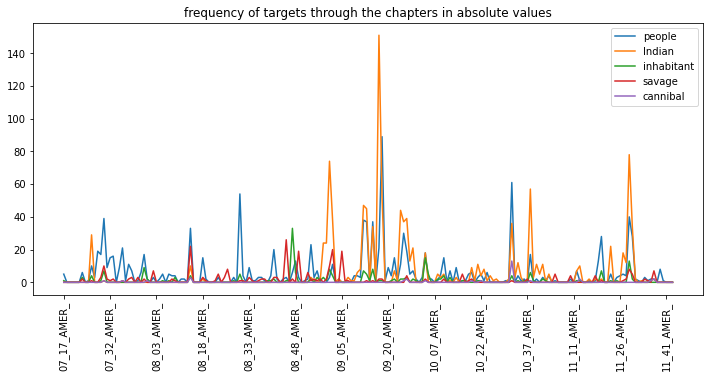

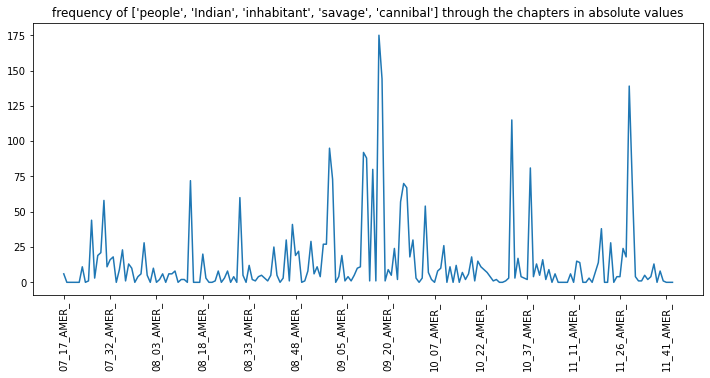

In [105]:
track_words_chapters(hakluyt_AMER, ['people', 'Indian', 'inhabitant', 'savage', 'cannibal'], words_mode = 'separate', count_mode = 'absolute')
track_words_chapters(hakluyt_AMER, ['people', 'Indian', 'inhabitant', 'savage', 'cannibal'], words_mode = 'grouped', count_mode = 'absolute')

##### Penguins & dragon excursion

71  penguins counted through freqdist
48  penguins counted directly from corpus


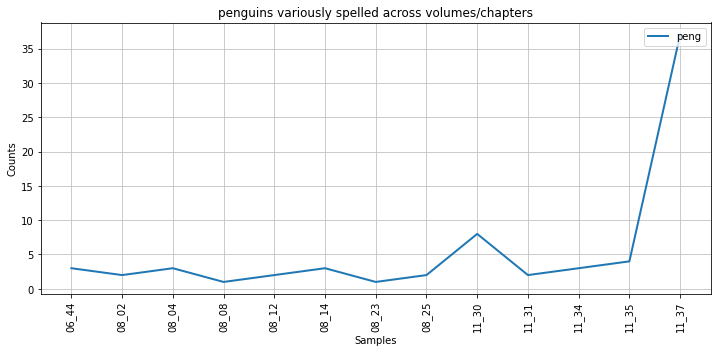

<AxesSubplot:title={'center':'penguins variously spelled across volumes/chapters'}, xlabel='Samples', ylabel='Counts'>

In [106]:
peng_list = ['penguines', 'penguins', 'penguinstand', 'penguin', 'pengwin', 'pengwins', 'pengwyns', 'pengwins', 'penguins', 'penguinisle']
peng_count = 0
for peng in peng_list: peng_count += hakluyt_fd[peng]
print(peng_count, ' penguins counted through freqdist')


peng_count = 0
for fileid in hakluyt.fileids():
    for w in hakluyt.words(fileid):
        if 'peng' in clean_token(w):
            peng_count += 1
            
print(peng_count, ' penguins counted directly from corpus')


hk_penguin_track = nltk.ConditionalFreqDist(('peng', fileid[:5])
                                       for fileid in hakluyt.fileids()
                                       for w in hakluyt.words(fileid)
                                       for target in peng_list
                                       if w.lower() == target)
plt.title('penguins variously spelled across volumes/chapters')
hk_penguin_track.plot()

As expected, penguins are sharply concentrated in just one chapter, which likely accounts for their appearance on the topic model

In [332]:
dragon_count = 0
for fileid in hakluyt.fileids():
    for w in hakluyt.words(fileid):
        if 'dragon' in clean_token(w):
            dragon_count += 1
            
print(dragon_count, ' dragons counted directly from corpus')


hk_dragon_track = nltk.ConditionalFreqDist(('dragon', fileid[:5])
                                       for fileid in hakluyt.fileids()
                                       for w in hakluyt.words(fileid)
                                       if 'dragon' in w.lower())
plt.title('dragons across volumes/chapters')
hk_dragon_track.plot()

Dragons seem a rarer sight; document hunting shows the most prominent dragon chapter to be dealing with a ship by that name; some others attach 'dragon' to implausible elephant-eating snakes.

## violence tracking ##


##### code

In [107]:
from nltk import FreqDist
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from itertools import repeat

In [108]:
def extract_neighbors(text, targets, n, stop_words, include_targets):
    '''
    text : input text as a list of word tokens
    targets : list of keywords of interest
    n : number of words to either side around the keyword
    stop_words : tokens to be skipped; if a token is skipped, the window is extended to make up to the number required
    include_targets : boolean flag determining whether the return will include the keyword of interest or not
    returns a list of lists, each a window of 2n / 2n+1 words centered on keyword
    '''
    #adjustment variables to account for not/including target
    include_target_index_adjust = 0 if include_targets else 1
    include_target_length_adjust = 1 if include_targets else 0
    #initialize return array
    neighbors = []
    #iterate through all the words
    for index, word in enumerate(text):
        if word in targets:
            neighbors_right = []
            neighbors_left = []
            #right side
            right_index = index + include_target_index_adjust
            right_target = index + n 
            while right_index <= right_target:
                if text[right_index] not in stop_words:
                    neighbors_right.append(text[right_index])
                else:
                    right_target += 1
                if right_target < len(text):    
                    right_index += 1
                else:
                    #add empty members
                    while len(neighbors_right) < n + include_target_length_adjust:
                        neighbors_right.append('')
                    #exit text-add loop
                    right_index = right_target + 1
            #left side
            left_index = index - 1
            left_target = index - n
            while left_index >= left_target:
                if text[left_index] not in stop_words:
                    if left_index >= 0:
                        neighbors_left.append(text[left_index])
                    else:
                        neighbors_left.append('')
                else:
                    left_target -= 1
                if left_target > -1:
                    left_index -= 1
                else:
                    #add empty members
                    while len(neighbors_left) < n:
                        neighbors_left.append('')
                    #exit text-add loop
                    left_index = left_target - 1
            neighbors_left.reverse()
            neighbors.append(neighbors_left + neighbors_right)
    return(neighbors)

In [109]:
# for file in hakluyt_lem.fileids():
#     print(extract_neighbors(hakluyt_lem.words(file), viol_flags, 5, stop_words_max, False))
#     break
# for file in hakluyt_lem.fileids():
#     print(extract_neighbors(hakluyt_lem.words(file), viol_flags, 5, stop_words_max, True))
#     break
# test = list(range(-10,11))
# print(extract_neighbors(test, [-9, 5, 10], 3, [], True))

In [110]:
def rank_window(window):
    '''
    takes a list of words presumed to reflect the n neighbors on both sides of a target word
    returns a list of word weighed towards the center--multiplying the words closest to the target
    '''
    #for a window with even number of members, the two center-tied numbers get the highest n/2 multiplier
    ranked_window = []
    if len(window)%2 == 0:
        index = 0
        multiplier = 1
        while index < len(window):
            ranked_window.extend(repeat(window[index], multiplier))
            #ranked_window += window[index] * multiplier
            if index < len(window)/2 - 1:
                multiplier += 1
            elif index > len(window)/2 -1:
                multiplier -= 1
            # in the omitted case of index = n, multiplier doesn't need to change anyway
            index += 1
    #for a window with an uneven number of members, the center number gets the highest (n+1)/2 multiplier
    else:
        index = 0
        multiplier = 1
        while index < len(window):
            ranked_window.extend(repeat(window[index], multiplier))
            if index < (len(window)+1)/2 - 1:
                multiplier += 1
            else:
                multiplier -= 1
            index += 1
    return(ranked_window)

In [111]:
#rank_window(['1', '2', '3', '4', '5', '6', '7'])

In [112]:
def neighbors_fdist(corpus, targets, n, stop_words, include_targets, ranked):
    '''
    corpus: nltk corpus
    targets : list of keywords of interest
    n : number of words to either side around the keyword
    include_targets : boolean flag determining whether the return will include the keyword of interest or not
    ranked: boolean flag weighing the words closest to the keyword higher than those further away
    returns: nltk fdist of the words surrounding the keywords in targets
    '''
    # init word list
    neighbor_words = []
    for file in corpus.fileids():
        neighbors = extract_neighbors(corpus.words(file), targets, n, stop_words, include_targets)
        for window in neighbors:
            if ranked:
                neighbor_words += rank_window(window)
            else:
                neighbor_words += window
            #print(neighbor_words)
    fdist = FreqDist(neighbor_words)
    #print(fdist.most_common(100))
    return(fdist)

In [113]:
def neighbors_wordcloud(corpus, targets, n, stop_words, cloud_words, include_targets, ranked):
    '''
    corpus: nltk corpus
    targets : list of keywords of interest
    n : number of words to either side around the keyword
    stop_words : list of words to leave out of the image
    cloud_words : number of words to be represented in the image
    include_targets : boolean flag determining whether the return will include the keyword of interest or not
    ||| not yet implemented||| ranked: boolean flag weighing the words closest to the keyword higher than those further away
    prints a wordcloud representing the n words around targets in the corpus
    '''    
    fdist = neighbors_fdist(corpus, targets, n, stop_words, include_targets, ranked)
    wcloud_prep = dict([(term, count) for term, count in fdist.items() if len(term)> 2])  #(stop_words_max)]) #(stop_words_max | set(viol_flags))])
    wcloud = WordCloud(width=800, height=400, relative_scaling = 1, min_word_length=2, max_words = cloud_words).generate_from_frequencies(wcloud_prep)  
    #plt.figure(figsize=(20,10))
    plt.imshow(wcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [114]:
# #comparison tables for different parameters

# #range slide
# length=100
# neighbors_track = pd.DataFrame()
# neighbors_track['range_1'] = neighbors_fdist(hakluyt_lem, viol_flags, 1, stop_words_max + viol_flags, include_targets = False, ranked = False).most_common(length)
# for i in range(2,6):
#     neighbors_track['range_'+str(i)] = compare_freqs(neighbors_track['range_1'], neighbors_fdist(hakluyt_lem, viol_flags, i, stop_words_max + viol_flags, include_targets = False, ranked = False).most_common(length))
# neighbors_track.T.style.apply(highlight_shifts)

# #ranking effect
# fdist_unranked = neighbors_fdist(hakluyt_lem, viol_flags, 3, stop_words_max + ['man', 'come'] + punctuation, include_targets = False, ranked = False)
# fdist_ranked = neighbors_fdist(hakluyt_lem, viol_flags, 3, stop_words_max + ['man', 'come'] + punctuation, include_targets = False, ranked = True)
# ranked_comp = pd.DataFrame()
# ranked_comp['unranked'] = fdist_unranked.most_common(100)
# ranked_comp['ranked'] = compare_freqs(fdist_unranked.most_common(100), fdist_ranked.most_common(100))
# ranked_comp.T.style.apply(highlight_shifts)

##### wordclouds

In [135]:
#print(neighbors_fdist(hakluyt_lem, viol_flags, 5, sw+viol_flags, include_targets = False, ranked = False).most_common(1000))

In [115]:
plt.figure(figsize=(20,10))
sw = stop_words_max + ['man', 'come'] + viol_flags + punctuation
neighbors_wordcloud(hakluyt_lem, viol_flags, 5, sw , cloud_words = 250, include_targets = False, ranked = False)
print(neighbors_fdist(hakluyt_lem, viol_flags, 5, sw, include_targets = False, ranked = False).most_common(250))

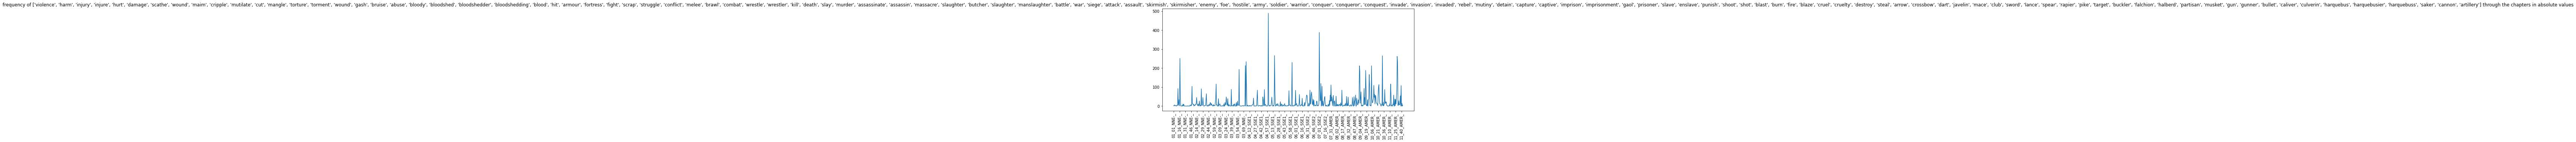

In [116]:
track_words_chapters(hakluyt_lem, viol_flags, words_mode = 'grouped', count_mode = 'absolute')

Gathering a sampling of meaning-bearing words occuring close to an extended list of violence-related words shows:
- other violence-words: even when excluding the flagged word itself, other violence-bearers show very prominently, reflecting the fact that violence comes as a broad thematic current rather than isolated word occurences
- ships clearly are very often involved, and then kings, captain is another clearly relevant signal; things like time & say are probably just spillovers from their overall frequency
- Indians make a notable appearance, though only about half the weight of combined Spaniard-Spanish-Spain or English-England-Englishman (~60% for ranges 1-2; ~50% for 3-5)
- extending the window too far results in a sampling that looks much like the top frequent words

- 'take' suggestively appears at the top of violence-neighbors list (after dispensing with higher-frequency words that are hard to tie to any specific meaning, such as 'great' or 'man'); I will refer to it as a second-tier instance: not obviously related to a query, but promising further insight on closer investigation
    - A concordance search does flag a few throwaways - 'take heed' or 'take for', but many are of clear relevance - 'take or kill yong birds', or 'take up souldiers out of every countrey of their dominions'. Many instances of 'take' do in fact constitute violence that escapes the keyword search - 'take the wealth of the countrey', 'take possession of this Island', and possibly 'take unto wife'
    - a wordclouds of 'take' neighbors brings out a lot of noise, but we also see direct violence indicators (slay, burn, kill) as well as intriguing potentials - taking a ship may relate to battle, taking land, islands, or taking possession sounds a lot like conquest, taking prisoner is clearly coercive, and taking 'negro' is clearly involved in slavery. Taking wives or women; taking victual, taking Indians or Spanish... Granted, some of the listed instances may involve the subject (i.e., Indian or woman) taking something else, but quickly commenting out the left-side gathering of neighboring words still leaves a considerable contingent of Indains, Negros and wives on the right side of 'take'.

In [156]:
hakluyt_col.concordance('mutinous', 200, 50)
#neighbors_wordcloud(hakluyt_lem, ['take'], 3, stop_words_max, cloud_words = 250, include_targets = False, ranked = False)

Displaying 9 of 9 matches:
 in the discover of those impediment , and answer the slander which by the vulgar malicious and mutinous sort be lay as blemish upon the journey , and reproach upon the general ( have indeed proceed f
hat if it shall happen any one or more in any ship or ship sail on their say voyage , to become mutinous , seditious , disorder , or any way unruly to the prejudice or hindrance of the hope for the su
undred ton a piece , with good store of ordinance , and well furnish with man : at who come our mutinous fellow be surprise , be not able to see they when they come , aswell because of the darkness of
the haven mouth : which i cause present to be put in execution . Loe here what be the end of my mutinous soldier , without which i have always live peaceable , and enjoy the good desire which i have t
service ; wherein assure they never after fail : so that i dare say , after the departure of my mutinous companion i be as well obey as ever be captain in place where he

violent neighbors across Hakluyt's entire compilation


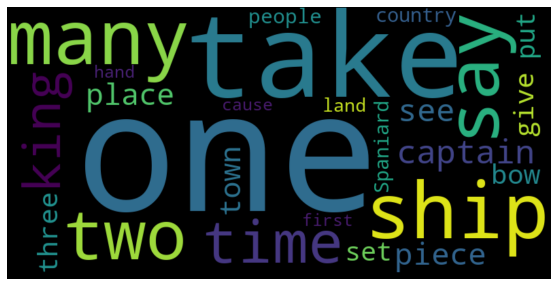

violent neighbors in just the American section


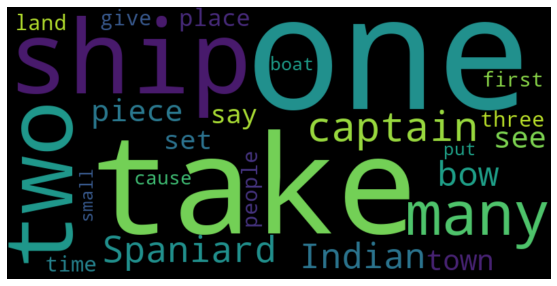

In [118]:
plt.figure(figsize=(10,5))
print('violent neighbors across Hakluyt\'s entire compilation')
neighbors_wordcloud(hakluyt_lem, viol_flags, 3, stop_words_max + ['man', 'come'] + viol_flags, cloud_words = 25, include_targets = False, ranked = False)
print('violent neighbors in just the American section')
plt.figure(figsize=(10,5))
neighbors_wordcloud(hakluyt_AMER, viol_flags, 3, stop_words_max + ['man', 'come'] + viol_flags, cloud_words = 25, include_targets = False, ranked = False)

In [119]:
wordfreqs_comp = pd.DataFrame()
wordfreqs_comp['total'] = neighbors_fdist(hakluyt_lem, viol_flags, 3, stop_words_max + ['man', 'come'] + viol_flags + punctuation, include_targets = False, ranked = False).most_common(250)
wordfreqs_comp['AMER'] = compare_freqs(neighbors_fdist(hakluyt_lem, viol_flags, 3, stop_words_max + ['man', 'come'] + viol_flags + punctuation, include_targets = False, ranked = False).most_common(250),
                                       neighbors_fdist(hakluyt_AMER, viol_flags, 3, stop_words_max + ['man', 'come'] + viol_flags + punctuation, include_targets = False, ranked = False).most_common(250))
wordfreqs_comp.T.style.apply(redbold_viol).apply(highlight_shifts)
# track_words_chapters(hakluyt_lem, ['Spaniard', 'Spain', 'spanish'], words_mode = 'grouped', count_mode = 'absolute')
# track_words_chapters(hakluyt_lem, ['Indian'], words_mode = 'grouped', count_mode = 'absolute')

Comparing the semantic neighborhood of violence in the American section vs all across the compilation, the renewed prominence of Spaniard and Indian certainly jumps out - from around #20 to #5; 'savage' jumps from #170 to #60. 

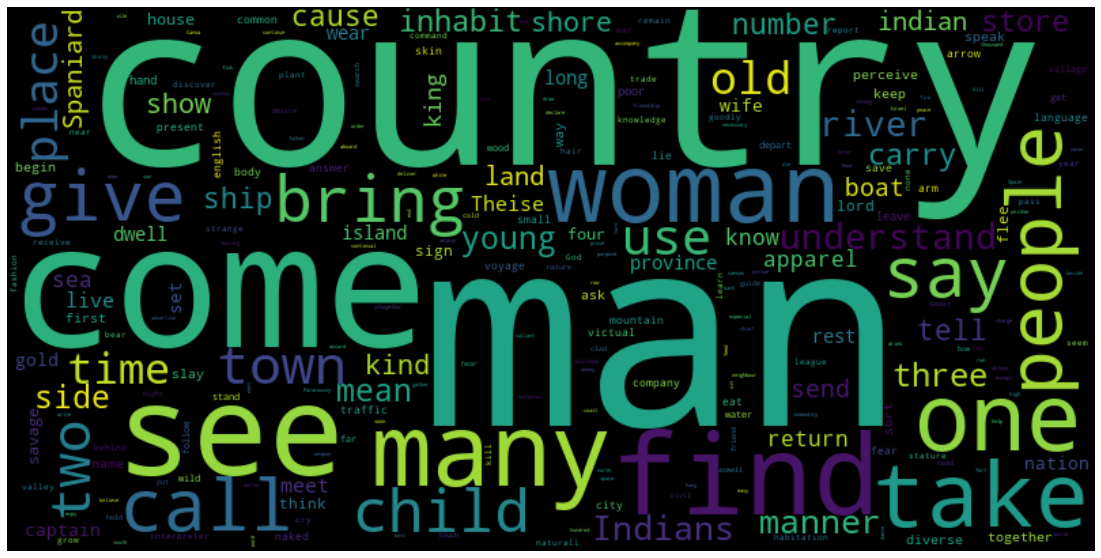

In [120]:
# hakluyt_col.similar('Indian')
# print('\n \n')
# enc_sig_col.similar('Indian')
plt.figure(figsize=(20,10))
nat_flags = ['indian', 'savage', 'cannibal', 'interpreter', 'inhabitant', 'naked', 'people', 'woman', 'child', 'cacique', 'Pemisapan']
neighbors_wordcloud(hakluyt_AM_enc_part_full, nat_flags, 3, stop_words_max, cloud_words = 250, include_targets = False, ranked = False)
nat_comp = pd.DataFrame()
nat_comp['Amer'] = neighbors_fdist(hakluyt_AMER, nat_flags, 3, stop_words_max + punctuation, include_targets = False, ranked = False).most_common(250)
nat_comp['enc_part_full'] = compare_freqs(nat_comp['Amer'],
                                       neighbors_fdist(hakluyt_AM_enc_part_full, nat_flags, 3, stop_words_max + punctuation, include_targets = False, ranked = False).most_common(250))
nat_comp['enc_full'] = compare_freqs(nat_comp['Amer'],
                                       neighbors_fdist(hakluyt_AM_enc_full, nat_flags, 3, stop_words_max + punctuation, include_targets = False, ranked = False).most_common(250))
nat_comp.T.style.apply(redbold_viol).apply(highlight_shifts)

- At relative scaling of 1 -- tying wordcloud text size directly to frequency--a lot of the hits are barely large enough to make out, suggesting that the lexical neighborhood isn't very consistent, thus featuring a lot of low-frequency stragglers

- Trying to get a sense of the bag-of-words representation of Native people is a harder case than violence:
  - (basically filling out the list of flags by scrutinizing the 'neighborhood' of the first intuitive guesses and testing / adding prospective additional hits--though afther the first few guesses, what I've been adding seems low-frequency enough that it doesn't change the picture much)
  - the list of words directly designating them is quite short - Indian and savage cover most general references, and 'inhabitant' is pretty reliable; Cacique, Pemipasan, and cannibal make for a few very specific references, but are pretty rare. 
  - People don't exclusively designate Native people, but do more often than not; interestingly, a little above half of Hakluyt's 'people' appear in ther American section. 
  - 'Naked' is a very reliable and quite meaningful designator; 
  - the women and children showing in these texts are, for clear historical reasons, largely non-European.

- Country shows up as the top hit (after eliminating meaning-light words such as 'great' and 'man'). It's definitely a second-tier signal,
  - Can I stretch it as far as 'Native people are closely tied to the land'?
  - add 'possess*', land, and animals / natural resources 
  - thus, 34,000 'dry' penguins (not to mention the majority of penguin-hunting that does not recount numbers) suggests no less than ecological devastation



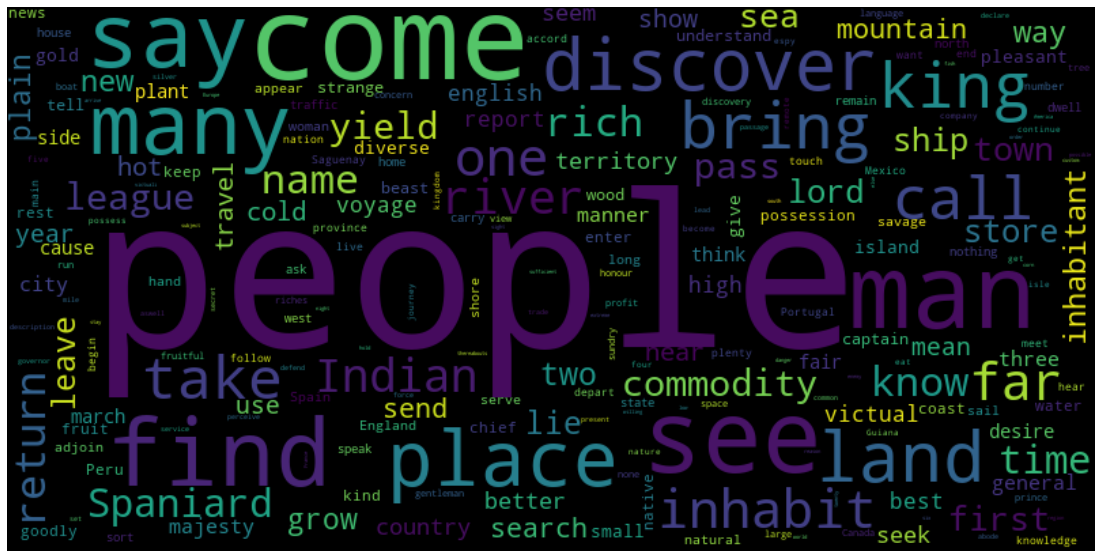

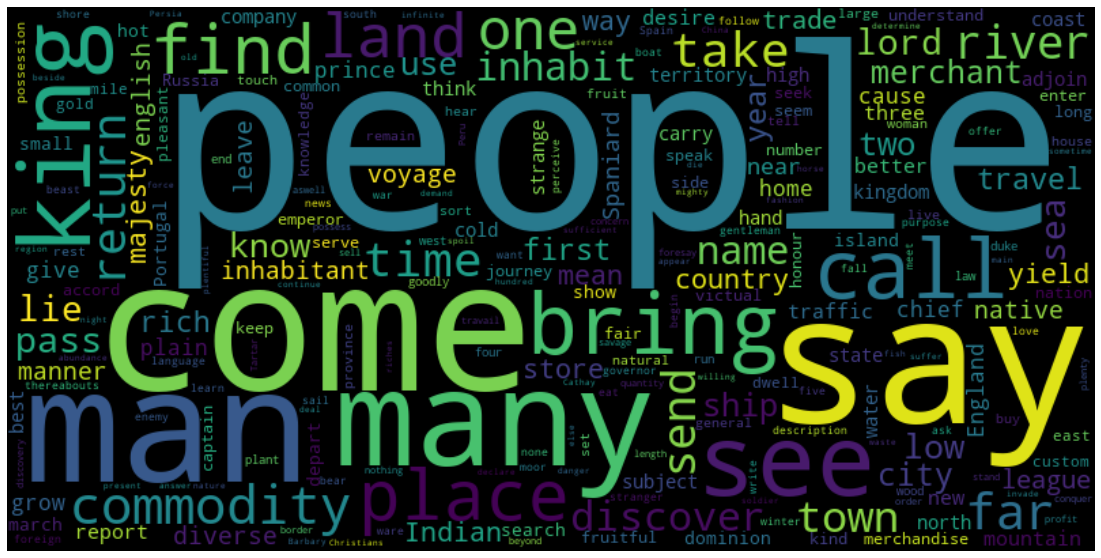

Displaying 22 of 1677 matches:
wn , where he see many strange thing . Humf . Lloyd . this land must needs be some part of that country of which the Spaniard affirm themselves to be the first finder since hannos time . whereupon it
affirm themselves to be the first finder since hannos time . whereupon it be manifest that that country be by Britain discover , long before Columbus lead any Spaniard thither . of the voyage and ret
 sure it be there he be . and after he have return home , and declare the pleasant and fruitful country hat he have see without inhabitant , and upon the contrary part , for what barren and wild the 
ain . therefore it be to be suppose that he and his people inhabit part of those Gomara . lib . country : for it appear by Francis Lopez de Gomara , » • cap . 16 . that in Acuzamil and other place th
 come unto , and use the language they find there . m . Powels this Madoc arrive in the western country , unto addition . the whjch he camejn the year 1170 , leave most 

In [121]:
plt.figure(figsize=(20,10))
neighbors_wordcloud(hakluyt_AMER, ['country'], 3, stop_words_max, cloud_words = 250, include_targets = False, ranked = False)
plt.figure(figsize=(20,10))
neighbors_wordcloud(hakluyt_lem, ['country'], 3, stop_words_max, cloud_words = 250, include_targets = False, ranked = False)
AMER_col.concordance('country', 200, 22)



## piecemeal violence tracking
Sweep through the corpus and note incidence of violence in the ledger:
- simple ratio of viol_flags out of all chapter words
- number of pages with same rate above certain threshold 

In [208]:
#helper functions proofed against sectioned chapter filename format
def get_text_volchap(filename):
    '''extract identifying information from typical HK corpus filename, cat_mod excepted
    returns list of two strings representing zero-filled-to-two-characters values for corresponding volume and chapter'''
    vol = filename[:filename.find('_')]
    filename = filename[filename.find('_') +1:]
    chap = filename[:filename.find('_')]
    return([vol, chap])
def get_row_volchap(row):
    '''extract identifying information from typical HK ledger row
    returns list of two strings representing zero-filled-to-two-characters values for corresponding volume and chapter'''
    vol = row['vol'].zfill(2)
    chap = row['chap']
    if '.' not in chap:
        chap = chap.zfill(2)
    return([vol, chap])

def get_text(corpus, volchap):
    '''finds HK text based on identifying information in volchap from corpus
    returns full text as a string'''
    root = 'text-data/'+corpus
    filelist = os.scandir(root)
    for entry in filelist:
        if get_text_volchap(entry.name) == volchap:
            with open(entry.path, mode = 'r', encoding="utf8") as f:
                text = f.read()
            break
    return(text)

def get_row(ledger, volchap):
    '''finds relevant ledger row based on identifying information in volchap from ledger
    returns row as dictionary'''
    root = 'text-data/' + ledger
    with open(root, mode = 'r') as ledger_csv:
        ledger_rows = csv.DictReader(ledger_csv) 
        for row in ledger_rows:
            if get_row_volchap(row) == volchap:
                return(row)
            
def viol_report(text):
    '''calculates the number and ratio of viol_flags in a text after filtering for punctuation'''
    tokens = text.split()
    words = [w for w in tokens if w not in punctuation]
    if len(words) == 0:
        return(0, 0)
    else:
        viols = 0
        for w in words:
            if w in viol_flags:
                viols += 1
                #print('viol', w)
            if w in viol_poss:
                viols+= 0.5
                #print('viol_p', w)
        #print(f'{viols} viol flags out of {len(words)} words')
        return(viols, viols / len(words))
    
def wordcount(text):
    '''counts words in text after filtering for punctuation'''
    tokens = text.split()
    return(len([w for w in tokens if w not in punctuation]))

In [212]:
#record violence content/ratio in new ledger
with open('text-data/ledger_merged_EN.csv', mode = 'r') as ledger3_csv:
    ledger_rows = csv.DictReader(ledger3_csv) 
    ledger_header = ledger_rows.fieldnames
    with open('text-data/ledger_m_EN_viol.csv', mode = 'a', newline='') as ledger4_csv:
        writer = csv.DictWriter(ledger4_csv, fieldnames=ledger_header)
        writer.writeheader()
        for row in ledger_rows:
            #for each row, grab text from corresponding file in full/sectioned corpus depending on chap '.' and record violreport in new ledger row
            #print(row)
            if '.' not in get_row_volchap(row)[1]:
                text = get_text('CC_ML_FR_trimmed_cleaned_EN_cl_MAlem', get_row_volchap(row))
            else:
                text = get_text('CC_ML_FR_trimmed_MAlem_AMER_cat_EN', get_row_volchap(row))
            report = viol_report(text)
            row['viol_num'] = report[0]
            row['viol_ratio'] = report[1]
            writer.writerow(row)

In [211]:
print(wordcount(get_text('CC_ML_FR_trimmed_MAlem_AMER_cat_EN', ['10','09.2'])))

1843


## topic modeling

#### gensim models

In [213]:
# imports
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
# import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# #pyLDAvis.gensim now updated to pyLDAvis.gensim_models
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim_models.prepare(ldamodel, doc_term_matrix, dictionary)
# vis

In [344]:
# gensim topic modeling starts with a list of strings, each string representing a document; tokenized into a list of lists of strings; BOW-ed, then vectorized into a dictionary
hakluyt_EN_pageschunked = PlaintextCorpusReader('text-data/CC_ML_FR_trimmed_cleaned_EN_cl_MAlem_chunked_pages', '.*')
H_tokenized = [hakluyt_EN_pageschunked.words(file) for file in hakluyt_EN_pageschunked.fileids()]

In [345]:
sw = stop_words_max + punctuation
H_tok_sw = []
for doc in H_tokenized:
    H_tok_sw.append([w for w in doc if not w in sw])
# print(H_AM_tok_sw[0][:200])

In [346]:
# Create Dictionary
id2word = corpora.Dictionary(H_tok_sw)
# Term Document Frequency
TDF = [id2word.doc2bow(text) for text in H_tok_sw]
# View
#print(TDF[:1])

In [126]:
#[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

In [127]:
# lda_model = gensim.models.ldamodel.LdaModel(corpus=TDF,
#                                            id2word=id2word,
#                                            num_topics=20, 
#                                            random_state=100,
#                                            update_every=1,
#                                            chunksize=100,
#                                            passes=10,
#                                            alpha='auto',
#                                            per_word_topics=True)
# lda_model.print_topics()
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim_models.prepare(lda_model, TDF, id2word)
# vis

In [128]:
# # mini experiment re bag-of-words & randomization
# import random

# for doc in H_AM_tok_sw:
#     random.shuffle(doc)
# print(H_AM_tok_sw[0][:50])
# # Create Dictionary
# id2word = corpora.Dictionary(H_AM_tok_sw)
# # Term Document Frequency
# TDF = [id2word.doc2bow(text) for text in H_AM_tok_sw]
# lda_model2 = gensim.models.ldamodel.LdaModel(corpus=TDF,
#                                            id2word=id2word,
#                                            num_topics=20, 
#                                            random_state=100,
#                                            update_every=1,
#                                            chunksize=100,
#                                            passes=10,
#                                            alpha='auto',
#                                            per_word_topics=True)
# lda_model2.print_topics()

In [355]:
mallet_path = 'C:/Users/apovzner/Documents/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=TDF, num_topics=60, id2word=id2word, optimize_interval=5, iterations=10000)
#ldamallet.show_topics(formatted=False)
mallet_to_gensim = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(mallet_to_gensim, TDF, id2word)
vis

C:\Users\apovzner\Miniconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=           x      y  topics  cluster   Freq
topic                                      
48    -0.036 -0.215       1        1  8.078
40    -0.024 -0.202       2        1  6.076
11     0.225 -0.068       3        1  4.702
42     0.238  0.024       4        1  4.235
28     0.132 -0.220       5        1  3.683
13     0.197 -0.076       6        1  3.559
59     0.083  0.081       7        1  3.133
1      0.266  0.144       8        1  3.026
24     0.253  0.187       9        1  2.739
19    -0.116 -0.074      10        1  2.461
12     0.114 -0.150      11        1  2.338
9      0.104 -0.095      12        1  2.201
7      0.097 -0.066      13        1  2.076
57     0.077  0.077      14        1  2.043
15    -0.242 -0.036      15        1  1.910
45     0.077  0.169      16        1  1.893
35     0.082 -0.088      17        1  1.878
20    -0.165 -0.080      18        1  1.815
54     0.084 -0.189      19        1  1.800
6     -0.129 -0.093      20        1  1.757
32     0.057 -0.126      21        1  1.754
2      0.077  0.155      22        1  1.718
37     0.047 -0.088      23        1  1.631
18     0.048 -0.163      24        1  1.622
10    -0.081 -0.096      25        1  1.618
43    -0.044  0.052      26        1  1.515
3      0.142 -0.058      27        1  1.492
17    -0.239 -0.028      28        1  1.332
16    -0.013 -0.124      29        1  1.330
29    -0.027 -0.071      30        1  1.306
58    -0.041 -0.029      31        1  1.233
22     0.036 -0.076      32        1  1.115
47    -0.155  0.098      33        1  1.111
31    -0.055  0.129      34        1  1.002
55    -0.026  0.034      35        1  0.991
41    -0.120 -0.084      36        1  0.989
23    -0.008  0.066      37        1  0.974
25    -0.035  0.065      38        1  0.974
0      0.113  0.217      39        1  0.957
56    -0.085 -0.075      40        1  0.953
8     -0.003 -0.074      41        1  0.928
50    -0.221  0.066      42        1  0.922
30    -0.062 -0.012      43        1  0.890
52     0.046 -0.013      44        1  0.817
51    -0.135  0.066      45        1  0.797
5     -0.102  0.120      46        1  0.776
14    -0.094  0.077      47        1  0.761
53    -0.068  0.002      48        1  0.752
38     0.025  0.129      49        1  0.748
33     0.059 -0.021      50        1  0.744
4     -0.160  0.089      51        1  0.614
46     0.049 -0.027      52        1  0.603
39    -0.127  0.041      53        1  0.586
26     0.095  0.124      54        1  0.583
44     0.043  0.068      55        1  0.559
49    -0.067  0.150      56        1  0.436
27    -0.071  0.048      57        1  0.395
21    -0.080  0.111      58        1  0.388
36     0.026  0.147      59        1  0.376
34    -0.058  0.083      60        1  0.305, topic_info=                   Term      Freq     Total Category  logprob  loglift
498                ship  6521.000  6521.000  Default   30.000   30.000
29                 king  3913.000  3913.000  Default   29.000   29.000
294               river  3142.000  3142.000  Default   28.000   28.000
677                hand  2714.000  2714.000  Default   27.000   27.000
84                  man  7653.000  7653.000  Default   26.000   26.000
28               island  2745.000  2745.000  Default   25.000   25.000
1370             league  2862.000  2862.000  Default   24.000   24.000
136                call  4203.000  4203.000  Default   23.000   23.000
634                town  2731.000  2731.000  Default   22.000   22.000
169                land  4155.000  4155.000  Default   21.000   21.000
89                  sea  3333.000  3333.000  Default   20.000   20.000
23              country  3726.000  3726.000  Default   19.000   19.000
1322            majesty  1550.000  1550.000  Default   18.000   18.000
402                wind  1974.000  1974.000  Default   17.000   17.000
318             captain  2868.000  2868.000  Default   16.000   16.000
3850           merchant  1807.000  1807.000  Default   15.000   15.000
551               wate

In [354]:
#mallet_to_gensim.show_topics(num_topics=60, num_words=30,formatted=True)

#### main findings

In [402]:
# pd.set_option('display.width', 1000)
# pd.set_option('max_colwidth', 1000)
pd.set_option('display.precision', 3)
# from pprint import pprint
x13_AM_lem_pch = pd.read_excel(r'mallet/13_AM_page_chunk.xlsx', sheet_name= 'keys')
x15_AM_lem = pd.read_excel(r'mallet/15_AM.xlsx', sheet_name= 'keys')
x30_AM_lem = pd.read_excel(r'mallet/30_AM.xlsx', sheet_name= 'keys')

x60_tot_ENpch = pd.read_excel(r'mallet/EN_pagechunk_tot&AMER.xlsx', sheet_name= 'tot_60_keys')
x40_AM_ENpch = pd.read_excel(r'mallet/EN_pagechunk_tot&AMER.xlsx', sheet_name= 'AM_40_keys')


### general notes and observations

**technical notes**
- MALLET does seem to outperform Gensim on the admittedly subjective test of how much sense the topics seem to make; processing MALLET's outputs in Excel is also more intuitive for me at this point, though pyLDAvis is a neat help for visualizing the relationships between the topics.
  - importing the topic-keys and doctopics outputs into Excel allows me a convenient interface to sort, name, and visually mark up the topics--for example, using blue cell background to denote Native-related topics, orange for violence, and to bolden / color words of interest within a topic.
  - Mallet's doctopics output includes a filepath column, formatted as "file:/C:/Users/ ... filename.txt".
    - Using Excel's Hyperlink formula, that is easily turned into a clickable link that displays only the file name (rather than the full path) and opens up the associated text file: =HYPERLINK(RIGHT(B2,LEN(B2)-6), RIGHT(B2, LEN(B2) - 103))
    - using a few more admittedly awkward Right formulas, I can adjust the file path to point to a folder that has not been lemmatized, increasing reading convenience at the expense of slight (1-5 words per page) imprecision in text boundaries: =HYPERLINK(CONCAT("C:\Users\apovzner\Documents\Hakluyt\text-data\CC_ML_FR_trimmed_cleaned_EN_cl_MAspel_chunked_pages",RIGHT(B2,LEN(B2)-102)), RIGHT(B2, LEN(B2) - 103))
    - between the sorting interface and the clickable links, it is quite convenient to spot-check ambiguous or otherwise interesting topics
  - the excel files accessed or referenced here, along with MALLET's raw outputs, are located in the 'mallet' folder
- Even at low topic numbers (10-15), there's a lot of apparent overlap between the topics. 
- non-English text, though less than 10% of the collection, was still a noticeable presence, both as exclusive topics and mixed in with English topics, until cleaned out (though I've clearly missed some, and I ususally get one Latin topic or so in my spreads)
  - at the extreme, of the 30 topics on 30.xls, 7 topics are non-English, nearly a quarter of the total number--the disproportion probably having to do with a trivially tight co-occurrence of the non-English word tokens on the occasions where Hakluyt presents the foreign original document before translating it
- breaking the text into page-long chunks seems to have made the topics more cohesive, though it's hard to make an evidence-based judgment: at higher topic numbers, there's just too much to compare, and at lower topic numbers, everything is necessarily vague. 
  - It certainly makes it easier to sample the documents associated with any given topic, as I only need to consider a brief passage rather than a quantity ranging from a median of 6.3 pages all the way to tens or (rarely) around a hundred pages. 
- as before, I've dealt both with full-corpus topic spreads and narrowing down to the American volumes

**content observations**
- across the different topic spreads, regardless of number or whole corpus vs American focus, the topics largely fall in the following categories: 
  - discovery and exploration, partly overlapping with nautical navigation and technical seafaring terminology; Northwestern passage may count either here or as a regional topic
  - regional topics: multiple South American / Spanish colonization topics, one for Virginia / English colonization, one for Canada / French colonization, and one or several dealing with the Far East in the American spreads; all these plus Russia, Iceland, Ottoman empire (with distinct topics addressing Jerusalem and it senvirons) and more in the complete corpus
  - etnographic topics focusing on Native (or non-European more broadly) partially overlap with regional topics
  - trade and commodity topics partially overlap with ethnography
  - violence and fighting, often connoting naval battles, tends to stick to some of the following: far east; Ottoman-European fighting; English-Spanish (often invoking the Armada and Francis Drake); occasionally attached to Native topics
  - legal-imperial discourse of grant and dominion
- **genuinely interesting recurring topics include one clearly denoting intercultural contact, featuring words such as "come indian give see say tell show sign woman answer understand mean"**

In [331]:
display(x13_AM_lem_pch.loc[x13_AM_lem_pch['t'] == 'nat_com'])
display(x15_AM_lem.loc[x15_AM_lem['t'] == 'intercult_enc'])
display(x30_AM_lem.loc[x30_AM_lem['t'] == 'contact?'])

i   par        t                                                                                                                                                                                                                                                                                                w
3  0  0.23  nat_com  come man indian make give see great say certain captain river day king people take thing bring tell show sign cause send call country begin lord place woman stay return leave answer soldier carry understand fort mean set rest house victual side speak boat way find pass near company old

i    par      %              t                                                                                                                                                                                                                                                                                                 w
12  12  0.218  0.078  intercult_enc  great come see say certain indians give day make river people call find take tell thing return country league mountain water begin sail lord show stay man land woman good far indian sign rest plain carry coast way seem near pass small always house send leave command answer discover four

i    par      %         t                                                                                                                                                                                                                                                                                         w
6  4  0.241  0.054  contact?  come river see give people man woman make bring tell house take show old thing answer lord great understand call certain sun dwell arm sign ask say carry speak day company rest know far leave war cry stay child young desire boat bow victual save apparel begin seem broad together

- **another is tied to religious discourse, clearly veering into polemics against non-Christian beliefs**

In [325]:
display(x60_tot_ENpch.loc[x60_tot_ENpch['t'] == 'religion'])
display(x40_AM_ENpch.loc[x40_AM_ENpch['t'] == 'religion'])

i    par         t                                                                                                                                                                                                                                                                                                                                             w
21  42  0.049  religion  god say church holy christ place prayer word people saint lord faith devil friar life christian heaven worship image religion father idol temple give child cross ceremony believe prophet monastery jerusalem receive world law jesus bless priest pilgrim pray call bishop christians soul hold devotion greek reverence lady preach body

i    par      %         t                                                                                                                                                                                                                                                                                                                                              w
15  14  0.076  0.021  religion  god honour king please christian religion life almighty majesty lord hand world name prince right heaven riches christ humble become emperor soul favour christians live empire mercy example happy savage call enjoy virtue arm govern lawful high faith valiant love justice law exceed grace use courage merciful government service word

### turning toward violence

Interestingly, at the lower topic number end, violence disappears almost entirely (10_AM.xlsx, 13_EN_pagechunk_AM.xlsx), though already at 15 topics it is fairly prominent (15_AM.xlsx).

I have settled at 60 topics for the full corpus and 40 for the American one--these spreads yield highly specific topics (if often repetitive) that invite close scrutiny. Both distributions have a long left tail: just one topic (general exploration) in the 15-20% range, one or two in 10-5%, 9 5-3%, and the rest (50 out of 60 or 30 out of 40) sub-3%. 

The basic topics of interest for this purpose are those dealing with non-European people, violence, and especially the overlap (or lack of such) between them. 

#### Violence in the 60-topic full-corpus spread

##### Violence-marked topics

In the total corpus 60-topic spread, we get 6 distinctly violent topics:

In [343]:
display(x60_tot_ENpch.query("i in (57,18,39,16,5,38)"))

i    par      %                  t                                                                                                                                                                                                                                                                                                                                                                                 w
6   57  0.149  0.041             battle                                                                         man come great make enemy shoot shot place fight side piece slay ordinance captain give fire town number take hurt march rest night company fort near assault spaniard begin four keep set soldier enter arrow first leave wound get way put present defend stand arm discharge small time perceive part 
11  18  0.087  0.024   law & punishment                                                                                        man king say death take wife house year die prison child woman marry come dead put live father call time prisoner carry daughter use bring life keep law body slay make justice old friend young rest serve name bear slave cause bind person remain husband poor month party hang matter 
15  39  0.073  0.020                war                                               king war great army prince city country soldier year man land call time christian enemy send people pay slay battle take tribute invade lord number mighty subdue castle order arm conquer kingdom chief christians horse force power peace emperor win beside sword spoil province besiege tartar horseman maintain field captain 
25  16  0.043  0.012       battle_En_Sp                                ship fleet english spanish sir england general great admiral fight spaniard lord spain king take drake lie sail send englishman tercera soldier francis navy gentleman force honourable lisbon indies cadiz portugal earl saint queen galley armada majesty flores hand number conduct army indian beside pedro revenge sink provision vice small 
49   5  0.013  0.004      Turkey_battle                                                         say great town lord turk master make day bulwark rhodes enemy come wall people repair man see sir spain breach shoot artillery host trench speak camp die assault word knight answer cause ditch plain earth england beat traverse abide ambassador religion postern bassa reverend lose send part saint mantellet siege 
54  38  0.010  0.003  Cyprus/Sp/Pg_wars  captain general day army colonel town soldier battery city earl artillery march commander antonio lieutenant sir enemy norris mustafa lisbon appoint slay service honourable wingfield francisco batter gate regiment bragadino attend gentleman portugal embark castle wall governor throw vanguard arsenal cortaine conde courage camp guard noble samson juan brey famagusta

The bottom 4 topics are at least partially localized: #38 is largely associated with Cyprus and with an English expedition against Spain & Portugal; #5 clearly focuses on Turkish hostilities, #16 is England versus Spain, and #39 evokes the Crusades, and indeed often deals with older historical materials (though also often touches, for example, on Prussian vs Polish engagements). The violence in #18 is largely judicial, at times manifesting in travellers' reports on the customs of faraway countries, at times featuring Europeans as prisoners of other European or further off nations. None of those are relevant to what we would intuitively mark as 'colonial violence'.

#57 is perhaps the most ambiguous, and also by far the weightiest at 4%--as mentioned above, after a 15% weight exploration topic, the 60-topic spread has 10 topics between 5%-3% each, and a long left tail after that, including ~30 sub-1% weight topics. Though we have "Spaniard" in the topic, it's only in the 28th place, accounting for a bare .6% of the topic, according to Mallet's topic-phrase report (CC_ML_FR_trimmed_cleaned_EN_cl_MAlem_chunked_pages_sw_all_60_topics_10000_iter_5_10_optim_diag__topicphrase.xml). Looking at the documents with the highest share of the topic, we see a lot of intra-European fighting, with the top place taken by a page from an account of Francis Drake's raid on the Spanish colonies. Though of the top 15 documents, only one (at 4th place) addressed colonial violence (Spanish - Indian), expanding the manual examination to the first 45 documents yielded 16 instances of colonial violence, a hefty 30%. At that point, the topic prominence within the documents went down to 40%, but these were still clearly battle reports--in fact, down 400 page-documents, I was still consistently seeing battle reports at topic prominence of only about 15% (becomes a little hit-and-miss about 10%, 640 documents down). I can't manually classify anything like a representative sample, so I'll have to stop at 45 with a strong impression that while we do see colonial violence in Hakluyt, it's not very prominent. 

Attempting to trace a mathematical correlation between this battle topic and Native topics yielded a consistent 0 correlation--staying at 0 between closely similar topics; if I have the right of it, the math of the LDA algorithm is such that all topics are strictly uncorrelated. There are topic modeling packages built on a correlated LDA algorithm, but I decided against venturing there, both on time & effort and also realizing that what I really care about is the interstection of Nat and viol at high ratios rather than correlation throughout the entire data columns.

LDAvis offers an alternative measure of association between topics through its visualization. However, trying to use it introduces too many intermediary steps for it to be a useful interpretative tool. While I cannot import an external Mallet topic spread into the visualizer, I can run Mallet through a Gensim wrapper and then send it over to LDAvis, though unfortunately that does not get captured within Jupyter Notebooks like other code cell output. Regardless, a violence topic much like #57 here is shown half-overlapping with three other topics, of which one clearly addresses Native Americans ("man, give, people, sign, show, boat, Indians, begin, river, bring, stay, hand, call, return, set, captain, cry, shore, indian, side, understand, leave, speak, sun, woman, small, rest, general, lay, carry"), and the other two--general human activity and populations, topics which are likely to address non-European populations in Hakluyt's texts. Another generic violence topic, at 2% weigh (versus 4% in the previous one), is strongly overlapping with topics of religion, trading, and legal terms. A separate topic spread run under the same parameters yielded a top violent topic (3.7%) overlapping with no topic at all, though closely neighboring two potential Native population topics).Observations from from LDAvis remain in line with 'some colonial violence, but not very prominent'.

Instead of assessing violent content through #57, a simple option is to count the number of typical violence words on each page:

In [367]:
#get a simple count of violence indicators to supplement the topic models
filelist = os.scandir('text-data/CC_ML_FR_trimmed_cleaned_EN_cl_MAlem_chunked_pages')
with open('text-data/TM_page_viol.csv', mode = 'w', newline='') as pviol_csv:
    writer = csv.writer(pviol_csv)
    writer.writerow(['id', 'violcount'])
    for entry in filelist:
        id = entry.name[:6] + entry.name.split('_')[-1][:-4]
        with open(entry.path, mode = 'r', encoding="utf8") as f:
            text = f.read() 
            viol = viol_report(text)[0]
        writer.writerow([id, viol])

Notably, Excel gives a full blown correlation of 1 between this count and #57-- and a similarly resolute 0 for the more specialized violent topics. Though there's an overwhelming association, there's still a great deal of variability on a graph plotting the two values; also, while #57 bottoms out about halfway through the corpus, the counter doesn't get to 0 until about 80% through the corpus. 27.5 is the highest value (several ambiguous violence flags are counted at 0.5); down 360 page-documents, at VC=10, some of the pages start missing the mark, but even at VC of 8, down ~600 documents, still mostly a good indicator. Neither VC not #57 are entirely fool-proof, but at the very least, a high count on both is a strong conformation of violence in the text.

As a side note, violence also shows up in topics concerned with the natural environment, reminding us of the ecological devastation of colonization (though certainly representing only a small slice of it)

In [378]:
display(x60_tot_ENpch.query("i in ([50])"))

i    par      %                   t                                                                                                                                                                                                                                                                                  w
14  50  0.074  0.021  commodities-animal  fish great beast store wild take find country bird kill kind see eat dog salt skin sort live call flesh water fowl meat hunt white foul fly man body plenty savage big wood place abundance certain dry whale small think use far deer feed bear sheep strange number seal catch

##### non-European people topics

Hakluyt's concern with faraway trade and travel naturally manifests in a large number of topics addressing non-European settings:

In [376]:
display(x60_tot_ENpch.query("i in (28,23,21,49,59,37,54,17,22,53,30,14,43,56,3,40,1,52,26,45)"))

i    par          %                     t                                                                                                                                                                                                                                                                                                                                                                                                         w
8   28  0.135  3.727e-02            local_geog                                                                                              call river great country town people place say day mountain city name pass part land certain side inhabit come journey dwell first near far lie inhabitant fall mile man province time diverse stand travel lake mighty contain south way see chief hand find north report situate speak four nation beyond 
9   23  0.133  3.667e-02   Native_descriptions                                                                                                                      make man head woman long use wear people certain colour great skin see foot part hair iron arrow black hang bow cover body manner hand face stone white thing side carry together leg arm water diverse stand naked kind apparel lie call length red neck ear wood sort common fire 
34  21  0.025  7.022e-03                Turkey                          turk grand signior galley tripoli bassa constantinople call ambassador christian commandment alexandria moor city christians port chio turkish present english john fox englishman venetian cyprus cairo syria barbary master nation mahomet french captive aleppo pass turquoise viceroy ducat sultan alger zante keeper poland greek asia vessel pay consuli candia janissary 
36  49  0.024  6.639e-03      Indian_landscape                                                                                          see indians certain great mountain water land sail take hill shore find return small high wind indian valley point near league pleasant plain night day country behold santa green begin command general ride follow fresh hand coast call seem show wood trinity view stay always make fire discover good firm 
37  59  0.023  6.433e-03      Spanish_SouthAM2                                                                        isle island cape saint west indies santa coast call hispaniola domingo stand canary puerto bay dominica cuba juan rico part hand small cruz place course jamaica spaniard inhabitant hide florida margarita santo havana frigate bahama grand mona sight bermuda spain burn rio sant india tierra april honduras firma lucar sack 
39  37  0.021  5.826e-03                Russia                                                       emperor russia moscow great country mile ruff astracan duke river nicholas colmogro russes cazan novogrod vologda tartar way english saint call north verst come year ivan dwina yeraslave volga castle narve town boris moscovie horse carry ware monastery sled pheodorowich lappia border part siberia winter house vologhda rezan moscovia low 
40  54  0.021  5.700e-03         Sp_S_Am_trade                                                                           great portugal king come ship pegu goa good city china cochin indies ormus india lade make malacca kingdom merchandise cloth pepper moor store small country call merchant year bengala gold thing horse place monson cambaia trade persia hand carry voyage rice jewel chaul commodity spice ruby elephant quantity silk near 
41  17  0.020  5.584e-03       Fr_N_Am_Natives                                king fort river soldier captain indians make discover indian french france paracoussy savage florida cause utina send village victual monsieur name certain league bark ribault wood day leave embark enemy number place silver lieutenant advertise house satourioua return vasseur subject sergeant frenchman afterward sail cut gourgues succour command resolve build 
42  22  0.019  5.182e-03          S_

Of the 20 topics, most address regions rather than inhabitants, though the distinction is perhaps forced--violence in either kind of topic would be worth scrutinizing. We do not see much direct violence indicators in those topics; when there is anything at all, it is usually in the tail of the word list. Thus, in #41, we see a soldier in the 37th place, but that is both a relatively indirect violent marker and not significant within the topic; a sample of associated documents shows little violence committed. 

#23, weighing 3.7% of the total (10th from the top), is by far the most significant of the non-European-people-focused topics, addressing ethnographic descriptions (which sometimes overlap with description of the natural life). 570 documents at over 10% of the topic; of them 61 feature over 10% of #57, but a significant portion of these describe military arrangements rather than active violence.

#22 is highly localized: out of 142 pagedocs with over 10% #22 in them, 123 are from vol 9 chapters 7-27, and 87 (60%) are from just 4 chapters: vol 9 ch 12, 13, 15, 18. 20 of the two 142 have #57 > 10%; most indeed account for Spanish-Nat (and reverse) violence.

#17 starts with "king fort river soldier captain indians"; forts, soldiers, and captains are often involved in violence, but a more direct indicator of violence, "enemy", doesn't show until 30th place. 
Spot-checking the topic shows largely peaceful interactions, though based in a French military fortified settlement.
The topic is in fact concentrated in a narrow stretch of the American volume, 08_57-09_05, dealing with Florida (and its Native inhabitants), from French settlement to Spanish overtake and  French revenge raid. Only 10 pages or so outside that span have 10% or more of the topic in them, while most of that stretch is within the 25-35% range. Of the ~140 pages with substantial #17 proportion (>13%), only 21 register substantial violence (#57>15%); interestingly, most of these concern French-Spanish engagements with Native people fighting on the French side, and a few addressing French involvement in inter-Native hostilities.
It is worth observing that violent overlaps don't seem to have much to do with #17's content (the top 20 violent pages of the topic only feature 12 instances of 'enemy' in 6 documents-- out of over 7000 words); rather, it is a matter of violent content in the non-#17 parts of the relevant documents (e.g., #57's contributions).

#45 is an altogether tiny topic ~.1%, with only two topics smaller than it. Only 39 page-documents have above 10% of #45 in them, and of them only 3 feature over 5% of #57: one with nothing violent in it, one with a brief account of inter-Non-European fighting, and one addressing an English-Spanish fight with some Native participation.

All these spot examinations of Native and violent topics reveal that we see some overlap between violence and non-European people in Hakluyt, but whether that 'some' is 10% or 30%, it does not give us a meaningful insight. What I really want to know is how much of the violence touches Native people as opposed to being between Europeans themselves. European presence is relatively easy to register, but Native people are more of a challenge given the diverse locations Hakluyt covers. A focus on the American sections simplifies that task, especially once the Far East chapters are omitted-- "Indian" and "savage" should become reliable flags.

#### The 40-topic American spread

The American spread is in many ways similar to the total one--indeed, it certainly belongs to the same discursive field, just with a narrower focus. Obviously, we lose references to Russia and the Ottoman empire, among many others (however, we retain Japan-China-Coray due to the way Hakluyt defined his geographical regions). As before, we can identify a few topics of interest featuring violence, and a few covering Native people and places; the ones addressing plants and animals as potential commodities will be worth looking at as well.

#1 is certainly intriguing, pointing to Native death and suffering but little indication of violence

In [456]:
display(x40_AM_ENpch.query("i in ([1])"))

i   par      %               t                                                                                                                                                                                                                                                                                              w
17  1  0.06  0.017  Nat-life/death  man woman child old wife drink die young year body live death sick disease sickness age daughter meat marry dead poison wound kill call earth bear cure black father husband let misery fear use hot nature name fall heal health love wash blood table swell air fast bed recover christian

As can be expected from the topic word list, this often corrseponds to ethnographic descriptions of Native life touching on the subjects of death and sickness (and, in a peculiar combination, on marriage). Another source of sickness words in the topics is Europeans falling sick, often of scurvy, the quintessential colonial disease.

#### violence

The American spread features a battle topic much like #57 of the total spread, with 40 of 50 words overlapping, and similarly correlated at a ration of 1 to the simple violence counter.

In [401]:
display(x40_AM_ENpch.query("i in ([13])"))
t57 = nltk.word_tokenize(str(list(x60_tot_ENpch.query("i in ([57])")['w'])))
t13 = nltk.word_tokenize(str(list(x40_AM_ENpch.query("i in ([13])")['w'])))
#print(t13, t57)
overlap = 0
for w in t57:
    if w.isalpha() and w in t13:
        print(w, end =" ")
        overlap+=1
print('\n',overlap, 'words overlapping')

i    par      %       t                                                                                                                                                                                                                                                                                                                     w
3  13  0.168  0.046  battle  man town come spaniard captain slay shot great enemy march shoot hurt indians fort number give side fight take soldier arrow piece general ordinance set place rest fire flee perceive force put fear present sudden assault prisoner company night arm small bow four wound defend stand near leave discharge kill

come great enemy shoot shot place fight side piece slay ordinance captain give fire town number take hurt march rest night company fort near assault spaniard four set soldier arrow leave wound put present defend stand arm discharge small perceive 
 40 words overlapping


Interestingly, while tot#57 had only a straggler 'spaniard', here Spaniard comes as the third top word, and indians--13th; the topicphrase report numbers 250 'spaniard' tokens versus 135 'indians' tokens out of a total of 12656 tokens in the topic. This is not quite enough to establish that intra-European violence shows up at twice the rate of colonial violence (there may, and in fact will be Spanish-Indian violence, and in any case there's other flags to consider for both Native and European violent actors), but it certainly is suggestive.

If the total spread had a broad peppering of violence topics through the ordered list, here there's a dramatic dropoff: after #13, 4th largest, the other overtly violent topics come at place 32 (#34) and 38 (#15).

#### topic overlap with high violent indicators
Having granted that, in thinking about the violence content of a not apparently violent topic, I want not the correlation but the overlap with #13 (for the AM case), it is easy to calculate, for every topic, how many of the documents with a significant share of this topic also have a significant share of #13 ('significant' here being set at >.1 as a matter of semi-educated guess). 

In [454]:
# from IPython.display import HTML
# x40_AM_ENpchDT = pd.read_excel(r'mallet/EN_pagechunk_tot&AMER.xlsx', sheet_name= 'AM_40_dt')
# HTML(x40_AM_ENpchDT.iloc[0:5,48:89].to_html(index=False))

This gives results between 0 and 0.25 (excepting the trivial 1 of #13). Given that out of the total 2,427 documents, 349 have #13 > .1 -- a 15% ratio--it makes sense to set .2 as a threshold of interest; this gives us topics ## 9,15,24,31,37,&38; 3&29 come just below at 0.19. Notably, three of these topics cover Native presence in one way or another (#3 is the top Native presence topic at 4% weight of the total, dealing with intercultural contact, #24 covers French involvement in Florida, and #9 covers the English pre-Jamestown enterprizes in Virginia).

#15 is the most expected one, covering wars in the Far East, #31 lists English and Spanish in close proximity, though with little overt indication of violence within the topic words, #37 is largely a list of English names. #38 is a general topic for seafaring--elevated violence content makes sense given how often battles take place on the seas.

Still, given the average 14% value, even the top of 25% (#38) is really not a significant finding

#### colonial viol / total viol ratio

From my erstwhile skimming through much of the American volume, I ended up with a strong impression that Hakluyt foregrounds intra-European violence (esp. En-Sp) while downplaying European violence against Native people. Having split my corpus into page-chunks, and with a fairly reliable indicator of violence through the main battle topic, I am in a good position to test that impression by flagging, for each page chunk, whether it contains [indian & savage were good intuitive guesses; spot-reading supplied arrow and salvage]; then I intersect that with #13 > 0.1 (or maybe .15 or .20). 

In [467]:
filelist = os.scandir('text-data/CC_ML_FR_trimmed_cleaned_EN_cl_MAlem_AMER_chunked_pages')
nat_flags = ['indian', 'indians', 'savage', 'savages', 'salvage', 'salvages', 'arrow', 'arrows']
with open('text-data/TM_AM_page_nat.csv', mode = 'w', newline='') as pnat_csv:
    writer = csv.writer(pnat_csv)
    writer.writerow(['id', 'nat'])
    for entry in filelist:
        id = entry.name[:6] + entry.name.split('_')[-1][:-4]
        with open(entry.path, mode = 'r', encoding="utf8") as f:
            text = f.read()
            tokens = [t.lower() for t in nltk.word_tokenize(text)]
            if any(w in tokens for w in nat_flags):
                nat = 1
            else:
                nat = 0
            writer.writerow([id, nat])

Having imported the native presence flag into the topic model doctopic sheet, I filter for #13 >= 0.1, and count 281 documents excluding the Pacific Ocean sections; of those, 139 flag for Native presence, a precise 50%.
Raising violence threshhold to >=0.15, I get 176 relevant pages, of which 85 are marked for Native presence, 48%.

50% of the violence of American colonization being directed against Native people is honestly more than I expected to find in Hakluyt, but it still represents a dramatic undercount; put differently, as Hakluyt thinks of armed conflict in and around America, he is as much concerned with intra-European (and especially English-Spanish) conflict as that between settlers and Natives--and that despite the centrality of the Black Spanish legend in English colonial discourse.

At this point, it will be helpful to re-examine pages with high proportion of Native topics, as well as topics dealing with colonial settlement and trade, to see what kinds of violence my #13 misses, which is likely to translate into the kinds of oppression that Hakluyt doesn't register as violence.

In [365]:
test = '01_12_NNE-_1249_A_Chronicle_of_the_Kings_of_Man_taken_out_of_M_Camdens_Chorographie_pp.025-041_52.txt'

print(test[:6] + test.split('_')[-1][:-4])

    # ledger_rows = csv.DictReader(ledger3_csv) 
    # ledger_header = ledger_rows.fieldnames
    # with open('text-data/ledger_m_EN_viol.csv', mode = 'a', newline='') as ledger4_csv:
    #     writer = csv.DictWriter(ledger4_csv, fieldnames=ledger_header)
    #     writer.writeheader()
    #     for row in ledger_rows:
    #         #for each row, grab text from corresponding file in full/sectioned corpus depending on chap '.' and record violreport in new ledger row
    #         #print(row)
    #         if '.' not in get_row_volchap(row)[1]:
    #             text = get_text('CC_ML_FR_trimmed_cleaned_EN_cl_MAlem', get_row_volchap(row))
    #         else:
    #             text = get_text('CC_ML_FR_trimmed_MAlem_AMER_cat_EN', get_row_volchap(row))
    #         report = viol_report(text)
    #         row['viol_num'] = report[0]
    #         row['viol_ratio'] = report[1]
    #         writer.writerow(row)

01_12_52
